In [ ]:
import myData
import numpy as np

#for pytorch docker image
#!pip install matplotlib

randomSeed = 12345
myData.rng = np.random.default_rng(randomSeed)

#dataPath = 'data'
dataPath  = 'Ex_' # for results
onlyRead = True

# 0.025 <= peakMinHeight< 0.15
if not onlyRead:
    dataPeak, dataBase = myData.genData(dataPath, 40000, lenSignal=512, baseOrder=7,
                                        peakCount=(5, 15), peakMinHeight=0.05, peakWidth=(5,21))

# X: Paek Y: Baseline Z: X+Y

gNoiseMax = 0.01
gBaseMin = 0.1
gBaseMax = 0.8

# X: Paek Y: Baseline Z: X + Y*rand([baseRatioMin, baseRatioMax])
trainX, trainY, testZZ, testXX, testYY = myData.prepareData(dataPath,readValidData=onlyRead, noiseMax=gNoiseMax,
                                                baseRatioMin=gBaseMin, baseRatioMax=gBaseMax, onlyPeak=False, trainRatio=0.5)
#trainX, trainY, testZZ, testXX, testYY = myData.prepareData(dataPath,readValidData=False, noiseMax=gNoiseMax,
#                                                baseRatioMin=gBaseMin, baseRatioMax=gBaseMax, onlyPeak=False, trainRatio=0.8)

dataWidth = len(trainX.T)
trainSize = len(trainX)
testSize = len(testXX)
print(f'trainSize : {trainSize}, testSize: {testSize}, dataWidth : {dataWidth}')


reading data from files..
reading done..
reading validation data from files..
All data are prepared.. X:(20000, 512), Y:(20000, 512), Z:(20000, 512)
trainSize : 20000, testSize: 20000, dataWidth : 512


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

print('torch version',torch.__version__)


testX = torch.as_tensor(testXX, dtype=torch.float32)
# testX = normalize(testX)
testY = torch.as_tensor(testYY, dtype=torch.float32)
#testY = normalize(testY)
testZ = torch.as_tensor(testZZ, dtype=torch.float32)

torch version 2.5.1+cu124


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*- # necessary for python 2, not required for python 3

#from myUtils import *
#from myUtils import myUtils, myTorch
#or
#import myUtils
#myTorch = myUtils.myTorch
#myUtils = myUtils.myUtils
#or
#import myUtils
#import importlib
#myTorch = importlib.reload(myUtils).myTorch
#myUtils = importlib.reload(myUtils).myUtils # runs last because of name, 'myUtils', conflict

'''
x: int or float or bool or str = 1
x: bytes = b"test"
# For collections, the type of the collection item is in brackets (Python 3.9+)
x: list[int] = [1]
x: set[int] = {6, 7}
x: tuple[float] = (1.2, 3.5)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(allData[1200],'m')
plt.grid(True)

plt.subplot(2,5,i)
plt.figure(figsize=(2,2))
plt.axis('off')
image = testSet[index].numpy().squeeze()
plt.imshow(image, cmap='gray')
'''

import sys
import numpy as np
import random

import time
from datetime import timedelta

import re

class myUtils:
    # class variables defined for C/C++ compatibility
    IntMax  = np.iinfo(np.int32).max # IntMin  == -IntMax - 1  # -IntMax로 사용해도 무리 없음
    LongMax = np.iinfo(np.int64).max # LongMax == -LongMax - 1 # -LongMax로 사용해도 무리 없음
    FloatMax  = np.finfo(np.float32).max # FloatMin  == -FloatMax
    DoubleMax = np.finfo(np.float64).max # DoubleMin == -DoubleMin

    @staticmethod
    def getVersion(printInfo:bool = True) -> tuple[str]:
        if printInfo:
            print('Python  version:', sys.version)
            print('Numpy   version:', np.__version__)
        return sys.version, np.__version__

    @staticmethod
    def checkVersion(majorVersion=3, minorVersion=9, printInfo:bool = True):
        if printInfo: print(f"You are using Python {sys.version_info.major}.{sys.version_info.minor}.")
        if sys.version_info.major >= majorVersion and sys.version_info.minor >= minorVersion: return True
        if printInfo: print(f"Python {majorVersion}.{minorVersion} or higher is required.")
        #sys.exit(1)
        return False

    @staticmethod
    def checkIterable(testObject):
        try:
          iter(testObject)
          return True
        except TypeError:
          return False

    # __name__ is for current main module
    # instance = stringObject('getVersion')
    #
    # import myUtils
    # instance = stringObject('getVersion', 'myUtils')(True)

    @staticmethod
    def stringObject(objectName, moduleName=__name__):
        return getattr(sys.modules[moduleName], objectName)

    @staticmethod
    def numberList(string:str) -> list:
        strList = re.findall(r"[-+]?\d*\.\d+|\d+", string)
        return [ eval(x) for x in strList ]

    @staticmethod
    def reloadPackage(importName):
        import importlib.util
        return importlib.reload( importName )

    @staticmethod
    def checkPackage(importName:str) -> bool:
        import importlib.util
        spec = importlib.util.find_spec(importName)
        return True if spec is not None else False

    @classmethod
    def installPackage(cls, importName, packageName = None, printInfo = True):
        import importlib
        if cls.checkPackage(importName):
            if printInfo: print(f'The package, {importName}, is already installed..')
            return True
        if packageName is None: packageName = importName
        if printInfo: print(f'The package, {importName}, is not installed. Installing {packageName}..')

        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", packageName])
        if printInfo:  print('Done..')
        return False

    class enum:
        def __init__(self, *data):
            self.enumData = tuple(data)

        def checkReturnName(self, xString):
            for x in self.enumData:
                #print(f'{x=}')
                if x in xString: return x
            return None

        def at(self, i:int):
            return self.enumData[i]

        def __call__(self, x):
            if x in self.enumData:
                return self.enumData.index(x)
            return -1

    # use perf_time() for code execution time + pending time + io time
    # myTimer = myUtils.Timer()
    # print(myTimer())

    @staticmethod
    def sleep(sleepTime:int or float):
        time.sleep(sleepTime)

    class Timer:
        def __init__(self, elapsedTime=0):
            self.elapsedTime = elapsedTime
            self.timeOrigin = time.process_time()

        def reset(self, elapsedTime=0):
            self.elapsedTime = elapsedTime
            self.timeOrigin = time.process_time()

        @staticmethod
        def sleep(sleepTime:int or float):
            time.sleep(sleepTime)

        def __call__(self, inSeconds=True):
            elapsedTime = time.process_time() - self.timeOrigin + self.elapsedTime
            if inSeconds: elapsedTime = int(elapsedTime)
            return timedelta(seconds=elapsedTime)

        def elapsedSeconds(self):
            elapsedSecs = time.process_time() - self.timeOrigin + self.elapsedTime
            return int(elapsedSecs)

    #try:
    #    print('Start training..')
    #    trainLog, testLog = myTrainer(trainLoader, testLoader, epochMax=1200)
    #except KeyboardInterrupt:
    #    myTrainer.saveModel()
    #    print('Training interrupted..')
    #    myUtils.stopExecution()  or raise myUtils.StopException()

    class StopException(Exception):
        def __init__(self, errMessage='StopException is raised..'):
            if errMessage is not None: print(errMessage)
            self.errMessage=errMessage

        def _render_traceback_(self):
            pass

        def __str__(self):
            return self.errMessage

    @staticmethod
    def inNotebook():
        return 'ipykernel' in sys.modules

    @staticmethod
    def stopExecution(errMessage='stopExecution is called..', exitCode = -1):
        if myUtils.inNotebook():
            raise myUtils.StopException(errMessage)
            return exitCode
        else:
            print(errMessage)
            sys.exit(exitCode)


    _randomSeed:int = 0
    _rng = np.random.default_rng()

    @classmethod
    @property
    def rng(cls):   return cls._rng

    @classmethod
    def setRandomSeed(cls, newSeed:int = -1):
        if newSeed ==  0:
            cls._rng = np.random.default_rng()
            return cls._rng

        if newSeed == -1: newSeed = 1795
        cls._randomSeed = newSeed
        cls._rng = np.random.default_rng(newSeed)
        np.random.seed(newSeed)
        random.seed(newSeed)
        return cls._rng

    @staticmethod
    def normalize(x, axis = -1):
        return (x - x.min(axis, keepdims=True) ) / x.ptp(axis, keepdims=True)

    @staticmethod
    def normalizeXY(x, y, axis = -1):
        xmin = x.min(axis, keepdims=True)
        x = x - xmin
        y = y - xmin
        xdelta = x.max(axis, keepdims=True)
        return x/xdelta, y/xdelta

    @staticmethod
    def standardize(x, axis=-1):
        return (x - x.mean(axis, keepdims=True) )/ x.std(axis, keepdims=True, ddof=1) # torch.standardize와 결과가 같도록 ddof 설정

# myTorch class definition
# make sure that pyTorch is installed

#from myUtils import myUtils
import torch
import torch.nn as nn
import torch.nn.functional as F

def _setDeviceGPU(deviceNo:int, clearCache:bool, printInfo:bool):
    hasGPU = torch.cuda.is_available() if deviceNo != -1 else False
    if hasGPU:
        myDevice=torch.device(f'cuda:{deviceNo}') # torch.device('cuda:0') == torch.device('cuda')
        torch.cuda.set_device(myDevice)
        if printInfo:
            print(f'# of GPU : {torch.cuda.device_count()}')
            deviceNo=torch.cuda.current_device()
            print(f'GPU: {torch.cuda.get_device_name(deviceNo)}, GPU No: {deviceNo}')
            print(f'CUDA capability: {torch.cuda.get_device_capability(myDevice)}')
        if clearCache: torch.cuda.empty_cache()
    else:
        myDevice=torch.device('cpu')
        if printInfo:  print(f'Pytorch will run on CPU')

    return myDevice

class myTorch:
    _rng = None
    @classmethod
    @property
    def rng(cls):   return cls._rng

    @staticmethod
    def setRandomSeed(newSeed:int = 0):
        # myUtils의 default_rng를 랜덤으로 초기화하고, myTorch는 그냥 둠
        if newSeed ==  0:
            cls._rng = myUtils.setRandomSeed()
            return cls._rng

        import os
        if newSeed == -1: newSeed = 1795
        torch.manual_seed(newSeed)
        if torch.cuda.is_available():
            #torch.cuda.manual_seed(newSeed)
            torch.cuda.manual_seed_all(newSeed) # if use multi-GPU

            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True

            cudaVersion = torch.version.cuda
            assert cudaVersion is not None, 'Cuda check error..'

            if float(cudaVersion) >= 10.2:
                os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"
            else: # cudaVersion >= 1.8.0
                torch.use_deterministic_algorithms(True)

        os.environ["PL_GLOBAL_SEED"] = str(newSeed)
        cls._rng = myUtils.setRandomSeed(newSeed)
        return cls._rng

    @staticmethod
    def standardize(x, dim = -1):
        return (x - x.mean(dim, keepdims=True) )/ x.std(dim, keepdims=True)

    @staticmethod
    def standardize_(x, dim = -1):
        # just for example
        x_std = x.std(dim, keepdims=True)
        x.sub_( x.mean(dim, keepdims=True) ).div_(x_std)

    @staticmethod
    def normalize(x, dim = -1):
        x = x - x.min(dim, keepdims=True).values
        return x / x.max(dim, keepdims=True).values

    @staticmethod
    def normalizeXY(x, y, dim = -1):
        xmin, _ = x.min(dim, keepdims=True)
        x = x - xmin
        y = y - xmin
        xdelta, _ = x.max(dim, keepdims=True)
        return x / xdelta, y / xdelta

    @staticmethod
    def getVersion(printInfo:bool=True):
        if printInfo: print('Pytorch version:', torch.__version__ )
        return torch.__version__

    # class variable
    _dataDim:int = -1
    _dataShape:int or tuple = -1
    _dataSize:int = -1
    _actUnit:str = ''
    _preAct:bool = True
    _batchNorm:bool = True
    _maxPool:bool = False
    _dropOut:int = 0

    # CPU: myTorch.setDevice(-1)
    # GPU: myTorch.setDevice(0) <- GPU ID : 0, 1, ...
    # torchObject.to(myTorch.device)는 torchObject.cpu()/torchObject.cuda() 중 아래처럼 선택함
    # if myTorch.hasGPU: torchObject = torchObject.cuda()
    # else: torchObject = torchObject.cpu()

    _myDevice = _setDeviceGPU(deviceNo=0, clearCache=False, printInfo=False)
    _useGPU:bool = False

    @classmethod
    def setDevice(cls, deviceNo:int = 0, clearCache:bool = True, printInfo:bool = True):
        cls._myDevice = _setDeviceGPU(deviceNo, clearCache, printInfo)
        cls._useGPU = cls._myDevice != torch.device('cpu')
        return cls._myDevice

    @classmethod
    @property
    def device(cls): return cls._myDevice

    # device는 GPU가 없으면 deviceCPU와 같으므로 device == deviceCPU 이면 GPU가 없다고 판단할 수 있음
    # 또는 useGPU를 이용할 수 있음
    @classmethod
    @property
    def deviceCPU(cls): return torch.device('cpu')

    # useGPU는 GPU가 없으면 False
    @classmethod
    @property
    def useGPU(cls): return cls._useGPU

    @classmethod
    @property
    def hasGPU(cls) -> bool:
        return torch.cuda.is_available()

    @staticmethod
    def toGPU(myObject):    return myObject.to(myTorch._myDevice)

    @staticmethod
    def toCPU(myObject):    return myObject.cpu()

    @staticmethod
    def onGPU(myObject):
        if isinstance(myObject, nn.Module):
            # 모델 중 아무 파라미터 하나만 체크함
            return next(myObject.parameters()).is_cuda
        return myObject.is_cuda

    @classmethod
    @property
    def dataDim(cls) -> int:
        assert cls._dataDim != -1, 'dataDim is not initialized. Use myTorch.setDefault() first!!!'
        return cls._dataDim
    @classmethod
    def setDataDim(cls, dim):
        cls._dataDim = dim

    @classmethod
    @property
    def dataShape(cls) -> int or tuple:
        assert cls._dataShape != -1, 'dataShape is not initialized. Use myTorch.setDefault() first!!!'
        return cls._dataShape

    @classmethod
    @property
    def dataSize(cls) -> int or tuple:
        assert cls._dataSize != -1, 'dataSize is not initialized. Use myTorch.setDefault() first!!!'
        return cls._dataSize

    @classmethod
    def downDataShape(cls, downCount:int) -> int:
        if cls._dataDim == 1:
            downShape  = cls._dataShape // 2**downCount,
        else:
            downShape = tuple([ x // 2**downCount for x in cls._dataShape if x != 1] )
        return downShape, np.prod(downShape)

    @classmethod
    @property
    def actUnit(cls) -> str:
        assert cls._actUnit != '', 'actUnit is not initialized. Use myTorch.setDefault() first!!!'
        return cls._actUnit

    @classmethod
    @property
    def batchNorm(cls) -> bool:
        return cls._batchNorm

    @classmethod
    @property
    def preAct(cls) -> bool:
        return cls._preAct

    @classmethod
    @property
    def maxPool(cls) -> bool:
        return cls._maxPool

    @classmethod #@@@@
    def ActUnit(cls, actUnit, dropOut = 0, inplace:bool=False):
        moduleDict = nn.ModuleDict([
                ['relu', nn.ReLU(inplace=inplace)],
                ['relu6', nn.ReLU6(inplace=inplace)],
                ['leakyrelu', nn.LeakyReLU(negative_slope=0.01, inplace=inplace)],
                ['gelu', nn.GELU()],
                ['selu', nn.SELU(inplace=inplace)],
                ['silu', nn.SiLU(inplace=inplace)],
                ['swish', nn.Hardswish(inplace=inplace)],
                ['elu', nn.ELU(inplace=inplace)],
                ['sigmoid', nn.Sigmoid()],
                ['tanh', nn.Tanh()],
                ['softsign', nn.Softsign()],
                ['softplus', nn.Softplus()],
                ['sigmoid', nn.Sigmoid()],
                ['silu', nn.SiLU(inplace=inplace)],
                ['identity', nn.Identity()]
        ])
        if actUnit == -1: actUnit = myTorch._actUnit
        actUnit = actUnit.lower()
        if actUnit not in moduleDict.keys():
            myUtils.stopExecution(f'actUnit({actUnit}) is not in modules in ActUnit..')

        if dropOut == -1: dropOut = myTorch._dropOut
        if dropOut ==  0: return  moduleDict[actUnit]

        assert 0 <= dropOut < 100, 'make sure that 0 <= dropOut < 100.'
        dropOutUnit = torch.nn.Dropout( p = dropOut/100.0 )
        return torch.nn.Sequential( moduleDict[actUnit], dropOutUnit )

    @staticmethod
    def setDefault(dataShape, preAct = True, actUnit= 'relu', batchNorm = True, dropOut = 0, maxPool = False, printInfo:bool = True):
        if isinstance(dataShape, int):
            myTorch._dataDim = 1
            myTorch._dataSize = myTorch._dataShape = dataShape
        else:
            assert 1<=len(dataShape)<=4, 'The dimension of data should be between 1 and 4..'
            myTorch._dataDim = len(dataShape)
            myTorch._dataSize = np.prod(dataShape)
            myTorch._dataShape =  dataShape[0] if myTorch._dataDim == 1 else tuple(dataShape)

        myTorch._actUnit = actUnit
        myTorch._preAct = preAct
        myTorch._batchNorm = batchNorm
        myTorch._maxPool = maxPool
        myTorch._dropOut = dropOut
        if not printInfo: return
        print(f'setDefault: dataDim={myTorch._dataDim} dataShape={myTorch._dataShape} {batchNorm=} {dropOut = } {preAct=} actUnit={myTorch._actUnit}')

    @staticmethod
    def freezeUpdate(myModel, freezeFlag:bool=True):
        assert isinstance(myModel, nn.Module), 'myModel must inherit nn.Module'
        for param in myModel.parameters():
            param.requires_grad = not freezeFlag

    @staticmethod
    def getParameterCounts(myModel, printInfo:bool=True):
        if not isinstance(myModel, nn.Module):
            print('myModel is not herited from nn.Module..')
            return 0

        parameterCounts = sum([p.numel() for p in myModel.parameters() if p.requires_grad])
        if printInfo: print(f'Number of parameters : {parameterCounts}')
        return parameterCounts

    # Unsqueeze(multiChaannel = (True or False) ) add Batch dimension and Channel dimension if necessary
    # dataDim은 따로 주지 않으면 myTorch.dataDim에서 가져옴
    class Unsqueeze(nn.Module):
        def __init__(self, multiChannel = False, dataDim = -1):
            super().__init__()
            self.dataDim = myTorch.dataDim if dataDim == -1 else dataDim
            self.multiChannel  = multiChannel

        def forward(self, x):
            # torch.squeeze(x)

            #print(f'Unsqueeze Beg: {x.shape=}, {x.ndim=}, {self.dataDim=}')

            if self.multiChannel:
                # 멀티 채널이고 입력이 데이터 차원과 같으면 배치 채널만 넣음
                if x.ndim == self.dataDim:   x = torch.unsqueeze(x, 0) # add batch size dimension to axis = 0
            else:
                # 단일 채널일 때 데이터 차원과 입력 차원이 같으면 먼저 배치 차원을 넣음
                if x.ndim == self.dataDim:   x = torch.unsqueeze(x, 0) # add batch size dimension to axis = 0
                # 입력 차원이 데이타 차원 + 1이면 배치 차원이 존재하므로 채널 차원만 넣음
                if x.ndim == self.dataDim+1: x = torch.unsqueeze(x, 1) # add channel dimension to axis = 1

            #print(f'Unsqueeze End: {x.shape=}, {x.ndim=}')
            return x

    class Unsqueeze1d(nn.Module):
        def __init__(self, multiChannel = False):
            super().__init__()
            self.multiChannel  = multiChannel

        def forward(self, x):
            # torch.squeeze(x)

            #print(f'Unsqueeze1d Beg: {x.shape=}, {x.ndim=}')
            if self.multiChannel:
                # 멀티 채널이고 입력이 데이터 차원과 같으면 배치 채널만 넣음
                if x.ndim == 2: x = torch.unsqueeze(x, 0) # add batch size dimension to axis = 0
            else:
                # 단일 채널일 때 데이터 차원과 입력 차원이 같으면 먼저 배치 차원을 넣음
                if x.ndim == 1: x = torch.unsqueeze(x, 0) # add batch size dimension to axis = 0
                # 입력 차원이 데이타 차원 + 1이면 배치 차원이 존재하므로 채널 차원만 넣음

                if x.ndim == 2: x = torch.unsqueeze(x, 1) # add channel dimension to axis = 1
            #print(f'Unsqueeze1d End: {x.shape=}, {x.ndim=}')
            return x

    # Squeeze() : 인수 없이 사용하면 0차원부터 차원이 1인 것을 전부 없앰
    # Squeeze(1): 1차원의 차원이 1인 것을 다 없앰
    # Squeeze((1, 3)): 1, 3차원의 차원이 1인 경우에만 없앰
    class Squeeze(nn.Module):
        def __init__(self, dim:int or tuple = -1):
            super().__init__()
            self.dim = dim

        def forward(self, x):
            if self.dim == -1: return torch.squeeze(x)
            return torch.squeeze(x, self.dim)

    @staticmethod
    def expandLayerLinear(ioList):
        #  [ ((16, 16), 256), (256, 128), (128, 128, 2), (128, 32), (32, 10) ]
        #  ->  [ ((16, 16), 256), (256, 128), (128, 128, 2), (128, 32), (32, 10) ] 로 변화를 시킴
        numLayer = len(ioList) # 최소 리스트는 입력, 중간, 출력으로 3개의 layer로 구성
        assert numLayer >= 1, 'The number of the layers should be greater than 1..'

        ioShape = [ ]
        for ioItem in ioList:
            if len(ioItem) < 2:
                print(f'The item of ioList should contains two elements at least.')
                myUtils.stopExecution()
            # 3번째 항목은 갯수
            if len(ioItem) == 2: ioShape += [ tuple(ioItem) ]
            else:
                if ioItem[0] != ioItem[1] and ioItem[2] != 1:
                    print(f'Both two sizes should be equal to repeat them.')
                    myUtils.stopExecution()
                ioShape += [ tuple(ioItem[:2]) for _ in range(ioItem[2]) ]

        return ioShape

    @staticmethod
    def BatchNormXd(num_features:int, momentum = 0.1, affine:bool = True, dataDim:int = -1):
        if dataDim == -1: dataDim = myTorch._dataDim
        assert 1<= dataDim <= 3, 'dataDim should be between 1 and 3'

        BatchNorm = getattr(sys.modules['torch.nn'], f'BatchNorm{dataDim:1d}d')
        #BatchNorm = stringObject(f'BatchNorm{dataDim:1d}d', 'torch.nn')
        return BatchNorm(num_features, momentum=momentum, affine=affine)

        #batchNorm = f'nn.BatchNorm{dataDim:1d}d({num_features}, momentum={momentum}, affine={affine})'
        #return eval(batchNorm)

        """
        if dataDim == 1:
            return nn.BatchNorm1d(num_features, momentum=momentum, affine=affine)
        if dataDim == 2:
            return nn.BatchNorm2d(num_features, momentum=momentum, affine=affine)
        return nn.BatchNorm3d(num_features, momentum=momentum, affine=affine)
        """

    @staticmethod
    def BatchActUnit(xSize, actUnit = -1, batchNorm = -1, dataDim = -1):
        if actUnit   == -1: actUnit   = myTorch.actUnit
        if batchNorm == -1: batchNorm = myTorch.batchNorm
        if dataDim   == -1: dataDim   = myTorch.dataDim

        mainProc = []
        if batchNorm: mainProc += [ myTorch.BatchNormXd(xSize, dataDim = dataDim) ]
        if actUnit:   mainProc += [ myTorch.ActUnit(actUnit) ]
        if not mainProc: mainProc =  [ nn.Identity() ]
        return nn.Sequential(*mainProc)

    @staticmethod
    def LinearOnly(xSize:int, ySize:int):
        return nn.Linear(xSize, ySize)

    @staticmethod
    def LinearCell(xSize:int, ySize:int, preAct = -1, actUnit = -1, batchNorm = -1 ):
        if preAct  == -1: preAct  = myTorch.preAct

        mainProc = []
        if preAct: mainProc += [ myTorch.BatchActUnit(xSize, actUnit, batchNorm, dataDim = 1) ]
        mainProc += [ nn.Linear(xSize, ySize) ]

        if not preAct: mainProc += [ myTorch.BatchActUnit(ySize, actUnit, batchNorm, dataDim = 1) ]

        if preAct: print(f'  BatchNorm and ReLU..')
        print(f'Linear: {xSize=} -> {ySize=}')
        if not preAct: print(f'  BatchNorm and ReLU..')
        print('----------------')

        return nn.Sequential(*mainProc)

    @staticmethod
    def LinearCellBeforeAdd(xSize:int, ySize:int, preAct = -1, actUnit = -1, batchNorm = -1 ):
        if preAct  == -1: preAct  = myTorch.preAct

        mainProc = []
        if preAct: mainProc += [ myTorch.BatchActUnit(xSize, actUnit, batchNorm, dataDim = 1) ]
        mainProc += [ nn.Linear(xSize, ySize) ]

        if not preAct: # 더하고 난 다음에 Activation Layer를 적용해야 하므로 여기서는 Batch Normalization Layer만 적용함
            if batchNorm: mainProc += [ myTorch.BatchNormXd(ySize, dataDim = 1) ]

        if preAct: print(f'  BatchNorm and ReLU..')
        print(f'Linear: {xSize} -> {ySize}..')
        if not preAct: print(f'  BatchNorm..')
        print('----------------')

        return nn.Sequential(*mainProc)

    # LinearCell과 LinearCellBeforeAdd은 Convolution이 1개, LinearCellResNet은 Convolution이 2개
    class LinearCellResNet(nn.Module):
        def __init__(self, xSize:int, ySize:int, preAct = -1, actUnit = -1, batchNorm = -1, xyMode = 'min' ):
            super().__init__()
            if preAct  == -1: preAct  = myTorch.preAct

            if   xyMode == 'min' : mSize = xSize if xSize < ySize else ySize
            elif xyMode == 'max' : mSize = xSize if xSize > ySize else ySize
            else:  mSize = xSize if xyMode != 'post' else ySize

            self.procX = myTorch.LinearCell(xSize, mSize, preAct, actUnit, batchNorm)
            self.procY = myTorch.LinearCellBeforeAdd(mSize, ySize, preAct, actUnit, batchNorm)

            self.procR = self.actUnit = None
            if ySize != xSize: self.procR = myTorch.LinearCellBeforeAdd(xSize, ySize, preAct, actUnit, batchNorm)

            print(f'  Add..') if preAct else print(f'  Add and ReLU..')
            print('----------------')

            if not preAct: self.actUnit = myTorch.ActUnit(actUnit)

        def forward(self, x):
            z  = self.procY( self.procX(x) )
            z  += self.procR(x) if self.procR else x

            return z if not self.actUnit else self.actUnit(z)

    @staticmethod
    def InitialLinear(ioShape:tuple or list, preAct = -1, actUnit = -1, batchNorm = -1 ):
        if preAct == -1: preAct  = myTorch.preAct
        # initialLinear는 ioShape:(xShape, ySize)에서 ySize가 0일 때 Batch 차원만 데이터에 넣어 반환함
        # 이때 출력은 Batch Normalization과 Activation Unit을 거치서 나온 데이타임
        xShape, ySize = ioShape #
        if xShape == -1: xShape = myTorch.dataShape
        (xDim, xSize) = (1, xShape) if type(xShape) == int else (len(xShape), np.prod(xShape))

        # Unsqueeze로 Batch dimension만 삽입 후 Data dimension만 1차원으로 만듦
        # add Batch dimension if necessary. 사실은 데이터가 하나일 경우에 대비하는 것임
        mainProc = [ myTorch.Unsqueeze(dataDim = xDim), nn.Flatten() ]

        if ySize:
            # 입력에 BatchActUnit을 먼저 사용하면 입력 데이타가 양수만으로 한정되기 때문에 Weighting Layer를 먼저 적용해야 함
            mainProc += [ myTorch.LinearOnly(xSize, ySize) ]
            if not preAct: mainProc += [ myTorch.BatchActUnit(ySize, actUnit, batchNorm, dataDim = 1) ]

            print(f'InitialLinear: {xSize} -> {ySize}..')
            if not preAct: print(f'  BatchNorm and ReLU..')
            print('----------------')
        return nn.Sequential(*mainProc)

    @staticmethod
    def FinalLinear(ioShape:tuple or list, preAct = -1, actUnit = -1, batchNorm = -1 ):
        # ioShape: (xSize, yShape)
        # yShape은 분류 범주의 개수일 수도 있고, 아니면 회귀를 위한 출력 형식일 수도 있음
        if preAct == -1: preAct  = myTorch.preAct

        inSize, outShape = ioShape

        mainProc = []
        if inSize != np.prod(outShape):
            if preAct:
                mainProc += [ myTorch.BatchActUnit(inSize, actUnit, batchNorm, dataDim = 1) ]
                print(f'  BatchNorm and ReLU..')

            mainProc += [ myTorch.LinearOnly(inSize, np.prod(outShape)) ]

        if type(outShape) != int and  len(outShape) > 1:
            # Batch 차원은 유지하고, 출력 모양을 yShape로 변형
            mainProc += [ nn.Unflatten(-1, outShape) ]

        print(f'FinalLinear: {inSize} -> {outShape}..')

        # 만약 데이터가 1개 짜리면 Batch 차원을 없앰
        mainProc += [ myTorch.Squeeze() ]
        return nn.Sequential(*mainProc)

    @staticmethod
    def SimpleLinear(ioLayer:list or tuple, resNet = False, resNetMode = 'min', preAct = -1, actUnit = -1, batchNorm = -1, expandLayer = True ):
        # resNet을 사용하면 ioShape이 두 배로 변함
        # ioLayer = [ (512, 1) (256, 2), (128, 1) -> [ 512, 256, 256, 128 ] if resNet == False
        #         else -> [ 512, 256, 256   256, 256, 256   256, 128, 128  ]
        if expandLayer: ioLayer = myTorch.expandLayerLinear(ioLayer)
        numLayer = len(ioLayer)

        assert numLayer >= 2, 'The number of the layers should be greater than or equal to 2..'
        if resNet:
            mainProc = [ myTorch.LinearCellResNet(ioShape[0], ioShape[1], preAct, actUnit, batchNorm, resNetMode) for ioShape in ioLayer ]
        else:
            mainProc = [       myTorch.LinearCell(ioShape[0], ioShape[1], preAct, actUnit, batchNorm) for ioShape in ioLayer ]
        return nn.Sequential(*mainProc)

    @staticmethod
    def MaxPoolXd(kernel_size, stride = None, padding = 0, dilation = 1, ceil_mode:bool = False, dataDim:int = -1):
        if dataDim == -1: dataDim = myTorch._dataDim
        assert 1<= dataDim <= 3, 'dataDim should be between 1 and 3'

        MaxPool = getattr(sys.modules['torch.nn'], f'MaxPool{dataDim:1d}d')
        return MaxPool(kernel_size, stride, padding, dilation, ceil_mode = ceil_mode)

    @staticmethod
    def AdaptiveAvgPoolXd(output_size, dataDim:int = -1):
        if dataDim == -1: dataDim = myTorch._dataDim
        assert 1<= dataDim <= 3, 'dataDim should be between 1 and 3'

        AdaptivePool = getattr(sys.modules['torch.nn'], f'AdaptiveAvgPool{dataDim:1d}d')
        return  AdaptivePool(output_size)

    @staticmethod
    def ConvXd(inCh:int, outCh:int, kernel_size, stride, padding = 0, dilation = 1,
               groups:int = 1, bias:bool = True, padding_mode:str = 'zeros', dataDim:int = -1):
        if dataDim == -1: dataDim = myTorch._dataDim
        assert 1<= dataDim <= 3, 'dataDim should be between 1 and 3'

        ConvXd = getattr(sys.modules['torch.nn'], f'Conv{dataDim:1d}d')
        return ConvXd(inCh, outCh, kernel_size, stride, padding, dilation, groups, bias, padding_mode)

    @staticmethod
    def ConvTransposeXd(inCh:int, outCh:int, kernel_size, stride, padding = 0, output_padding = 0,
                groups:int = 1, bias:bool = True, dilation = 1, padding_mode:str = 'zeros', dataDim:int = -1):
        if dataDim == -1: dataDim = myTorch._dataDim
        assert 1<= dataDim <= 3, 'dataDim should be between 1 and 3'

        ConvXd = getattr(sys.modules['torch.nn'], f'ConvTranspose{dataDim:1d}d')
        return ConvXd(inCh, outCh, kernel_size, stride, padding, output_padding, groups, bias, dilation, padding_mode)

    @staticmethod
    def expandLayerCNN(ioList):
        # [(1, 16, 'down'), (16, 16, 'same', 2), (16, 24, 'down'), (24, 24, 2), (24, 36)]
        # -> [(1, 16, 'down'), (16, 16, 'same'), (16, 16, 'same'), (16, 24, 'down'), (24, 24, 'auto'), (24, 24, 'auto'), (24, 36, 'auto')]
        numLayer = len(ioList) # 최소 리스트는 입력, 중간, 출력으로 3개의 layer로 구성
        assert numLayer >= 1, 'The number of the layers should be greater than 1..'

        ioShape = [ ]
        for ioItem in ioList:
            if len(ioItem) < 2:
                print(f'The item of ioList should contains two elements at least.')
                myUtils.stopException()
            if type( ioItem[0] ) != int or  type( ioItem[1] ) != int:
                print(f'The first two items of ioList should be integers.')
                myUtils.stopException()

            itemCount = 1
            if len(ioItem) >= 4: # 4 항목 이상은 무시^^
                ioItemX = list(ioItem[:3])
                itemCount = ioItem[3]
            elif len(ioItem) == 3:
                if type(ioItem[2]) == int:
                    ioItemX = [ioItem[0], ioItem[1], 'auto']
                    itemCount = ioItem[2]
                else:
                    ioItemX = list(ioItem)
            else:
                ioItemX = [ioItem[0], ioItem[1], 'auto']

            if itemCount == 1: ioShape += [ tuple(ioItemX) ]
            else: ioShape += [ tuple(ioItemX) for _ in range(itemCount) ]

        return ioShape

    # downShape = [(1, 16, 'down'), (16, 16,'same'), (16, 24,'down'), (24, 24, 2),  (24,  36, 'down')]
    # up, down을 앞에 배치
    # (1, 16, 'down') -> [(16, 16, 'same')],
    #                    [(16, 24, 'down'), (24, 24, 2) ],
    #                    [(24, 36, 'down')]
    @staticmethod
    def separateLayerCNN(ioShape):
        mainLayer = []
        indexX = indexY = 0
        channelSize = []
        for i in range(1, len(ioShape) ):
            if ioShape[i][2]=='down' or ioShape[i][2]=='up':
                indexY = i
                mainLayer.append( ioShape[indexX:indexY] )
                channelSize.append( ioShape[indexY-1][1] )
                indexX = i
        mainLayer.append( ioShape[indexX:] )
        return mainLayer, channelSize

    # upShape = [(36, 24, 'up'), (24, 24,'same'), (24, 16,'up'), (16, 16,'same'),  (16, 1, 'up')]
    # up, down을 뒤에 배치
    # [(16, 16, 'same'), (16, 1, 'up') ]
    # [(24, 24, 'same'), (24, 16, 'up')],
    # [(36, 24, 'up')]
    @staticmethod
    def separateUpLayerCNN(ioShape):
        mainLayer = []
        indexX = indexY = 0
        for i in range( len(ioShape) -1 ):
            if ioShape[i][2]=='down' or ioShape[i][2]=='up':
                indexY = i+1
                mainLayer.append( ioShape[indexX:indexY] )
                indexX = i+1

        mainLayer.append( ioShape[indexX:] )
        return mainLayer

    #         128, (1, 128),      (16, 16),   (1, 16, 16),   (3, 16, 16),      (16, 16, 16),   (1, 16, 16, 16),   (3, 16, 16, 16)
    # -> (1, 128), (1, 128), (1, (16, 16)), (1, (16, 16)), (3, (16, 16)), (1, (16, 16, 16)), (1, (16, 16, 16)), (3, (16, 16, 16))
    #        128 ,     128,       (16, 16),      (16, 16),   (3, 16, 16),      (16, 16, 16),      (16, 16, 16),   (3, 16, 16, 16)
    @staticmethod
    def resolveShape( inShape: int or tuple or list ):
        if type(inShape) == int: return 1, inShape, inShape
        # 아래는 (4, (16, 16))과 같은 형태로 왔을 때 제일 앞을 채널로 인식
        if type(inShape[0]) == int and type(inShape[1]) == tuple or type(inShape[1]) == list:
            return inShape[0], inShape[1], ( inShape[0], *inShape[1] )
        # 아래는 ( 1 or 3, 16, 16) 과 같은 형태로 왔을 때 1과 3을 채널로 인식
        inShapeX = []
        for x in inShape:
            inShapeX += list(x) if type(x) != int else [x]

        print(inShapeX)
        if len(inShapeX) == 2 and inShapeX[0] == 1: return 1, int(inShapeX[1]), int(inShapeX[1])
        if inShapeX[0] == 1: return 1, tuple( inShapeX[1:] ), tuple( inShapeX[1:] )
        if inShapeX[0] == 3: return 3, tuple( inShapeX[1:] ), tuple( inShapeX )
        return 1, tuple(inShapeX), tuple(inShapeX)

    @staticmethod
    def ConvOnly(inCh:int, outCh:int, convType:str = 'auto', kernel_size = -1):
    # auto (outCh == 0 -> bypass)
    # up, down, same : kernel_size = -1 이면 kernel_size는 4, 4, 3 for up, down, same
    # same1x, bypass : kernel_size의 영향을 안 받음

        dataDim = -1 # 인수가 너무 많아지므로 dataDim은 디폴트 값으로 설정..
        #print('ConvOnly', inCh, outCh)
        if convType == 'auto':
            if   outCh == 0:     convType = 'bypass'
            elif inCh  > outCh:  convType = 'up'
            elif inCh  <  outCh: convType = 'down'
            else:                convType = 'same'

        if convType == 'bypass': return nn.Identity()
        # padding = kernet_size//2
        if convType == 'same1x':
            # (N+2P-K)//S + 1 = N+2P-K+1 = N+2*0-1+1 = N-1+1 = N
            return myTorch.ConvXd(inCh, outCh, kernel_size=1, stride=1, padding=0, dataDim = dataDim)

        # assume N is even!!!
        if convType == 'same':
            # 'same' : kernel_size should be odd!!!
            # padding = kernel_size//2
            if kernel_size == -1: kernel_size = 3
            stride, padding = 1, kernel_size//2
            convXd = myTorch.ConvXd(inCh, outCh, kernel_size, stride, padding, dataDim = dataDim)
            # (N+2P-K)//S + 1 = N+2P-K+1 = N+2*1-3+1 = N-1+1 = N
            #convXd = myTorch.ConvXd(inCh, outCh, kernel_size=3, stride=1, padding=1)
        elif convType == 'down':
            # even kernel size is preferred!!!
            # padding = kernel_size//2
            if kernel_size == -1: kernel_size = 4
            stride, padding = 2, (kernel_size-1)//2

            if myTorch.maxPool:
                tempProc = [ myTorch.MaxPoolXd(kernel_size, stride, padding, dataDim = dataDim) ]
                # channel수를 맞추기 위해  convolution을 사용함
                if inCh != outCh: tempProc += [ myTorch.ConvXd(inCh, outCh, 3, 1, 1, dataDim = dataDim) ]
                convXd = nn.Sequential( *tempProc )
            else:   convXd = myTorch.ConvXd(inCh, outCh, kernel_size, stride, padding, dataDim = dataDim)

            # (N+2P-K)//S + 1 = (N+2*0-1)//2 + 1 = (N-1)//2 + 1 = N//2 - 1 + 1 = N//2
            #convXd = myTorch.ConvXd(inCh, outCh, kernel_size=1, stride=2, padding=0) # down
            # (N+2P-K)//S + 1 = (N+2*0-2)//2 + 1 = (N-2)//2 + 1 = N//2
            #convXd = myTorch.ConvXd(inCh, outCh, kernel_size=2, stride=2, padding=0) # down
            # (N+2P-K)//S + 1 = (N+2*1-3)//2 + 1 = (N-1)//2 + 1 = N//2 - 1 + 1 = N//2
            #convXd = myTorch.ConvXd(inCh, outCh, kernel_size=3, stride=2, padding=1) # down
            # (N+2P-K)//S + 1 = (N+2*1-4)//2 + 1 = (N-2)//2 + 1 = N//2
            #convXd = myTorch.ConvXd(inCh, outCh, kernel_size=4, stride=2, padding=1)
            # (N+2P-K)//S + 1 = (N+2*2-6)//2 + 1 = (N-2)//2 + 1 = N//2
            #convXd = myTorch.ConvXd(inCh, outCh, kernel_size=6, stride=2, padding=2)

        else: # if convType == 'up':
            # even kernel size is preferred!!!
            # padding = (kernel_size-1)//2, output_padding = kernel_size%2
            if kernel_size == -1: kernel_size = 4
            stride, padding, output_padding = 2, (kernel_size-1)//2, kernel_size%2
            convXd = myTorch.ConvTransposeXd(inCh, outCh, kernel_size, stride, padding, output_padding, dataDim = dataDim)

            # (N-1)*S - 2P + K = (N*2-2) - 2*0 + 1 = 2N - 1 -> output_padding is needed for odd number
            #convXd = myTorch.ConvTransposeXd(inCh, outCh, kernel_size=1, stride=2, padding=0, output_padding=1)
            # (N-1)*S - 2P + K = (N*2-2) - 2*0 + 2 = 2N
            #convXd = myTorch.ConvTransposeXd(inCh, outCh, kernel_size=2, stride=2, padding=0)
            # (N-1)*S - 2P + K = (N*2-2) - 2*1 + 3 = 2N - 1 -> output_padding is needed for odd number
            #convXd = myTorch.ConvTransposeXd(inCh, outCh, kernel_size=3, stride=2, padding=1, output_padding=1)
            # (N-1)*S - 2P + K = (N*2-2) - 2*1 + 4 = 2N
            #convXd = myTorch.ConvTransposeXd(inCh, outCh, kernel_size=4, stride=2, padding=1)
            #convXd = myTorch.ConvTransposeXd(inCh, outCh, kernel_size=6, stride=2, padding=2)

        return convXd

    @staticmethod
    def ConvCell(xSize:int, ySize:int, convType:str='auto', kernel_size = -1, preAct = -1, actUnit = -1, batchNorm = -1):
        # convType = 'auto', 'up', 'down', 'same', 'same1x', 'bypass'

        if preAct  == -1: preAct = myTorch.preAct

        mainProc = []
        if preAct: mainProc += [ myTorch.BatchActUnit(xSize, actUnit, batchNorm ) ]
        #print(f'ConvCell: {xSize=} {ySize=} {convType=}')
        mainProc += [ myTorch.ConvOnly(xSize, ySize, convType, kernel_size) ]
        if not preAct: mainProc += [ myTorch.BatchActUnit(ySize, actUnit, batchNorm ) ]

        return nn.Sequential(*mainProc)

    @staticmethod
    def ConvCellBeforeAdd(xSize:int, ySize:int, convType:str='auto', kernel_size = -1, preAct = -1, actUnit = -1, batchNorm = -1):
        # convType = 'auto', 'up', 'down', 'same', 'same1x', 'bypass'

        if preAct  == -1: preAct = myTorch.preAct

        mainProc = []
        if preAct: mainProc += [ myTorch.BatchActUnit(xSize, actUnit, batchNorm ) ]
        mainProc += [ myTorch.ConvOnly(xSize, ySize, convType, kernel_size ) ]
        if not preAct: # 더하고 난 다음에 Activation Layer를 적용해야 하므로 여기서는 Batch Normalization Layer만 적용함
            if batchNorm: mainProc += [ myTorch.BatchNormXd(ySize) ]

        return nn.Sequential(*mainProc)

    # LinearCell과 LinearCellBeforeAdd은 Convolution이 1개, LinearCellResNet은 Convolution이 2개
    class ConvCellResNet(nn.Module):
        def __init__(self, xSize:int, ySize:int, convType:str='auto', kernel_size = -1, preAct = -1, actUnit = -1, batchNorm = -1, xyMode = 'min'):
            super().__init__()
            if preAct  == -1: preAct  = myTorch.preAct

            convTypeX = convTypeY = convType
            if xyMode=='post' or (xyMode=='min' and ySize<xSize) or (xyMode=='max' and ySize>xSize): mSize = ySize; convTypeY = 'same'
            else: mSize = xSize; convTypeX = 'same'

            print(f'ConvCellResNet: {convTypeX=:4}, {convTypeY=:4}, {xSize=:4d}, {mSize=:4d}, {ySize=:4}')
            self.procX = myTorch.ConvCell(xSize, mSize, convTypeX, kernel_size, preAct, actUnit, batchNorm)
            self.procY = myTorch.ConvCellBeforeAdd(mSize, ySize, convTypeY, kernel_size, preAct, actUnit, batchNorm)

            self.procR = self.actUnit = None
            if ySize != xSize or ( convType == 'up' or convType == 'down' ):

                self.procR = myTorch.ConvCellBeforeAdd(xSize, ySize, convType, kernel_size, preAct, actUnit, batchNorm)
            if not preAct: self.actUnit = myTorch.ActUnit(actUnit)

        def forward(self, x):
            z  = self.procY( self.procX(x) )
            z  += x if self.procR is None else self.procR(x)

            return z if self.actUnit is None else self.actUnit(z)

    @staticmethod
    def ToLinearCNN(inShape:int or tuple, outSize:int, preAct = -1, actUnit = -1, batchNorm = -1):
        # CNN 스타일 데이타를 1차원으로 바꾼 다음 outSize 출력을 가진 Linear Layer를 통과시킴
        # 만약 np.prod(inShape)와 outSize가 같으면 그냥 1차원으로만 바꿔서 반환
        print(f'Flatten() -> LinearCell({np.prod(inShape)=}, {outSize=})')
        if outSize == np.prod(inShape): mainProc = [ myTorch.Unsqueeze(),  nn.Flatten() ]
        else: mainProc = [ myTorch.Unsqueeze(),  nn.Flatten() , myTorch.LinearCell( np.prod(inShape), outSize, preAct, actUnit, batchNorm)  ]
        return nn.Sequential( *mainProc )

    @staticmethod
    def FromLinearCNN(inSize:int, outShape:int or tuple or list, preAct = -1, actUnit = -1, batchNorm = -1):
        # 1차원 inSize 데이타를 outShape*outCh 출력을 가진 Linear Layer를 통과시킨 다음 outCh 채널, outShape 모양의 데이타를 만듦

        # Unsqueeze로 Batch dimension만 삽입 후 Data dimension만 1차원으로 만듦
        # add Batch dimension if necessary. 사실은 데이터가 하나일 경우에 대비하는 것임
        mainProc = [ myTorch.Unsqueeze1d(), nn.Flatten() ]

        _, _, outShape = myTorch.resolveShape(outShape)
        if inSize != np.prod(outShape):
            mainProc  += [ myTorch.LinearCell(inSize, np.prod(outShape), preAct, actUnit, batchNorm) ]

        # Batch dimension은 두고 나머지를  dataShape가 되게 만듦
        mainProc += [ nn.Unflatten(-1, outShape ) ]
        return nn.Sequential(*mainProc)

    @staticmethod
    def InitialCNN(layerShape, preAct = -1, actUnit = -1, batchNorm = -1):
        if preAct == -1: preAct =  myTorch.preAct
        inCh, outCh, convType = layerShape
        assert inCh > 0, 'initialCNN: inCh should be greater than 0'
        # 입력 데이터를 Batch, Channel, Data Size의 형태로 만들어 줌

        mainProc = [ myTorch.Unsqueeze( multiChannel = (inCh > 1 )  ) ]

        # outCh == 0 이면 입력 데이터에 대한 필터링 없이 Batch, Channel 차원만 넣어서 돌려줌 [ batch #, channel, [.. data .. ] ]

        # 입력에 BatchActUnit을 먼저 사용하면 입력 데이타가 양수만으로 한정되기 때문에 Weighting Layer를 먼저 적용해야 함
        mainProc += [ myTorch.ConvOnly(inCh, outCh, convType) ]
        if not preAct: mainProc += [ myTorch.BatchActUnit(outCh, actUnit, batchNorm ) ]
        # mainProc = [ myTorch.ConvCell or ConvOnly(1, outCh, 'same',
        #              nn.MaxPoolXd(kernel_size=4, stride=2, padding=1) ]
        return nn.Sequential( *mainProc )

    @staticmethod
    # 원하는 채널과 모양 혹은 분류를 위해 몇 개의 값을 가지도록 데이타를 출력하는 함수
    # outCounts가 0이 아니면 outShape은 무시하고 1차원으로 출력하고
    # 그렇지 않으면 AdaptiveAvgPool을 이용하거나 그냥 outShape로 만들어 출력
    def FinalCNN(inCh:int, outShape:int or tuple, convType = 'same', outCounts:int = 0, preAct = -1, actUnit = -1, batchNorm = -1):
        if preAct == -1: preAct =  myTorch.preAct

        outCh, outShape, _ = myTorch.resolveShape(outShape)
        mainProc = []
        if outCh != inCh:
            # 여기는 양수만의 출력이 나오게 할 수 없으니 Weighting Layer를 마지막에 배치함
            if preAct: mainProc += [ myTorch.BatchActUnit(inCh, actUnit, batchNorm ) ]
            print(f'FinalCNN: ConvOnly({inCh=}, {outCh=})')
            mainProc += [ myTorch.ConvOnly(inCh, outCh, convType) ]
        else: print(f'FinalCNN: ## No Convolution because {inCh=} == {outCh=}')
        if outCounts: #  분류하기 위한 경우에는 단순히 N개 값을 출력
            if outCounts == outCh*np.prod(outShape):
                print(f'FinalCNN: Flatten(), Squeeze()')
                mainProc += [ nn.Flatten(), myTorch.Squeeze()  ]
            else:
                print(f'FinalCNN: Flatten(), Linear( {outCh=}*{np.prod(outShape)=} ) = {outCh*np.prod(outShape)} , {outCounts=}), Squeeze()' )
                mainProc += [ nn.Flatten(), nn.Linear( outCh*np.prod(outShape), outCounts ), myTorch.Squeeze()  ]
            return nn.Sequential( *mainProc )

        # 여기부터는 Regression을 위해 outShape 모양으로 출력함
        if outShape != myTorch.dataShape:
            # 원래 데이타와 모양이 같지 않을 때 Regression 처리
            # AvgPool(k) makes the size of data be outSize without changing the number of channels
            print(f'Final CNN:  AdaptiveAvgPool({outShape=})')
            mainProc += [ myTorch.AdaptiveAvgPoolXd(outShape) ]

        # 채널이 하나만 있을 경우에는 채널 정보 제거 후 반환
        # 배치(0)는 두고 채널(1)부터 그 뒤로 1차원을 다 제거하는 다음 코드로 대체 가능
        # if outCh == 1: mainProc += [ nn.Squeeze(1) ]
        # 배치 혹은 채널이 1이면 다 없앰 ????
        mainProc += [ myTorch.Squeeze() ]
        return nn.Sequential( *mainProc )

    class SimpleCoreCell(nn.Module):
        # highCh, lowCh, inputCh가 0이면 해당 입력이 없고, -1이면 coreCh로 설정함
        # inputCh는 0이냐 아니냐만 의미가 있으며 0이 아닌 경우에는 자동으로 coreCh로 설정됨
        # coreCh(same), lowCh(down), highCh(up)은 각각 채널 수

        def __init__(self, coreCh:int, useInCh:bool=False, highCh:int=0, lowCh:int=0, resNet=True, preAct=True, actUnit = -1, batchNorm = -1):
            # self.preAct, self.resNet, self.inputCh, self.highCh, self.lowCh
            # self.highProcess, highProcessR, lowProcesss, lowProcessR, inputProcess, coreProcess
            super().__init__()

            if resNet == False: preAct =  False
            self.preAct = myTorch.preAct if preAct  == -1 else preAct
            if actUnit == -1: actUnit = torch.actUnit

            assert useInCh or lowCh or highCh, "SimpleCoreCell error: Both useInCh, lowCh, and highCh can't be 0.."

            print(f'  SimpleCoreCell = ', end='')
            mainProc = []
            self.useInCh = useInCh
            if highCh:
                if highCh == -1: highCh = coreCh
                self.highProcess = myTorch.ConvCellBeforeAdd(highCh, coreCh, 'down', -1, preAct, actUnit, batchNorm )
            if lowCh:
                if lowCh == -1: lowCh = coreCh
                self.lowProcess = myTorch.ConvCellBeforeAdd(lowCh, coreCh, 'up', -1, preAct, actUnit, batchNorm )

            # 더할 때는 더하고 난 다음 ReLU 즉 Activation Unit을 통과해야 함
            print(coreCh, useInCh, highCh, lowCh, resNet, preAct, actUnit, batchNorm)

            self.actUnit = myTorch.ActUnit(actUnit)

            self.coreProcessA = myTorch.ConvCell(coreCh, coreCh, 'same', -1, preAct, actUnit, batchNorm )
            self.coreProcessB = myTorch.ConvCellBeforeAdd(coreCh, coreCh, 'same', -1, preAct, actUnit, batchNorm )

            self.useInCh, self.lowCh, self.highCh, self.resNet = useInCh, lowCh, highCh, resNet
            print(f'{useInCh:3d}, {highCh:3d}, {lowCh:3d} -> outCh={coreCh:3d}')

        def forward(self, x = None, y = None, z = None):
            # x:inputCh, y:highCh, z:lowCh
            printInfo = False
            if printInfo:
                print('   Core', end=' ')
                if x is not None: print('x=', x.shape, end=' ')

            xA = x
            if y is not None:
                if printInfo: print('y=', y.shape, end=' ')
                yA = self.highProcess(y)
                xA = xA + yA if xA is not None else  yA
            if z is not None:
                if printInfo: print('z=', z.shape, end=' ')
                zA = self.lowProcess(z)
                xA = xA + zA if xA is not None else zA

            if not self.preAct: xA = self.actUnit(xA)

            outPut = self.coreProcessB( self.coreProcessA(xA) )
            if self.resNet: outPut += xA
            if not self.preAct: outPut = self.actUnit(outPut)

            if printInfo: print(f'-> {outPut.shape}')
            return outPut

    class CoreCell(nn.Module):
        # highCh, lowCh, inputCh가 0이면 해당 입력이 없고, -1이면 coreCh로 설정함
        # inputCh는 0, -1만 의미가 있으며 coreCh과 다른 값을 설정하면 에러가 남.
        # coreCh(same), lowCh(down), highCh(up)은 각각 채널 수

        def __init__(self, coreCh:int, useInCh:bool=False, highCh:int=0, lowCh:int=0, resNet=True, preAct=True, actUnit = -1, batchNorm = -1):
            # self.preAct, self.resNet, self.inputCh, self.highCh, self.lowCh
            # self.highProcess, highProcessR, lowProcesss, lowProcessR, inputProcess, coreProcess
            super().__init__()
            if resNet == False: preAct =  False
            self.preAct = myTorch.preAct if preAct  == -1 else preAct
            assert useInCh or lowCh or highCh, 'CoreCell error: Both useInCh, lowCh, and highCh can be 0..'

            print(f'     ResNetCNN = ', end='')
            if highCh:
                if highCh == -1: highCh = coreCh
                self.highProcess = myTorch.ConvCellBeforeAdd(highCh, coreCh, 'down', -1, preAct, actUnit, batchNorm )
                if resNet:
                    self.highProcessR = myTorch.ConvCellBeforeAdd(highCh, coreCh, 'down', -1, preAct, actUnit, batchNorm )
            if lowCh:
                if lowCh == -1: lowCh = coreCh
                self.lowProcess = myTorch.ConvCellBeforeAdd(lowCh, coreCh, 'up', -1, preAct, actUnit, batchNorm )
                if resNet:
                    self.lowProcessR = myTorch.ConvCellBeforeAdd(lowCh, coreCh, 'up', -1, preAct, actUnit, batchNorm )
            if useInCh:
                self.inputProcess = myTorch.ConvCellBeforeAdd(coreCh, coreCh, 'same', -1, preAct, actUnit, batchNorm )

            self.actUnit = myTorch.ActUnit(actUnit)
            self.coreProcess = myTorch.ConvCellBeforeAdd(coreCh, coreCh, 'same', -1, preAct, actUnit, batchNorm )

            self.useInCh, self.lowCh, self.highCh, self.resNet = useInCh, lowCh, highCh, resNet
            print(f'        {useInCh}, {highCh:3d}, {lowCh:3d} -> outCh={coreCh:3d}')

        def forward(self, x = None, y = None, z = None):
            # x:inputCh, y:highCh, z:lowCh
            printInfo = False
            '''
            if printInfo:
                print('   Core', end=' ')
                if self.useInCh: print('x=', x.shape, end=' ')

            xA = self.inputProcess(x) if self.useInCh else None
            if self.highCh:
                if printInfo: print('y=', y.shape, end=' ')
                yA = self.highProcess(y)
                yR = self.highProcessR(y) if self.resNet else None
                xA = xA + yA if xA else  yA
            if self.lowCh:
                if printInfo: print('z=', z.shape, end=' ')
                zA = self.lowProcess(z)
                zR = self.lowProcessR(z) if self.resNet else None
                xA = xA + zA if xA else zA
            '''
            #xShape = x if x is None else x.shape
            #yShape = y if y is None else y.shape
            #zShape = z if z is None else z.shape
            #print(xShape, yShape, zShape)

            if printInfo:
                print('CoreCell   Core', end=' ')
                if x is not None: print('x=', x.shape, end=' ')

            yR = zR = None

            xA = None if x is None else self.inputProcess(x)
            if y is not None:
                if printInfo: print('y=', y.shape, end=' ')
                yA = self.highProcess(y)
                if self.resNet: yR = self.highProcessR(y)
                xA = xA + yA if xA is not None else  yA
            if z is not None:
                if printInfo: print('z=', z.shape, end=' ')
                zA = self.lowProcess(z)
                if self.resNet: zR = self.lowProcessR(z)
                xA = xA + zA if xA is not None else zA
            # ----------------------------
            if not self.preAct: xA = self.actUnit(xA)

            outPut = self.coreProcess(xA)
            if self.resNet:
                if x is not None: outPut += x
            if yR is not None:
                #print(outPut.shape, yR.shape)
                outPut += yR
            if zR is not None:
                #print(outPut.shape, zR.shape)
                outPut += zR

            if not self.preAct: outPut = self.actUnit(outPut)
            if printInfo:
                print(f'-> {outPut.shape}')
                print(f'CoreCell End')
            return outPut

    @staticmethod
    def SimpleCNN(ioLayer:list, resNet = False, resNetMode = 'min', preAct = -1, actUnit = -1, batchNorm = -1, expandLayer = True ):
        # resNet을 사용하면 ioShape이 두 배로 변함
        if expandLayer: ioLayer = myTorch.expandLayerCNN(ioLayer)
        #print(ioLayer)
        numLayer = len(ioLayer)
        assert numLayer >= 1, 'The number of the layers should be greater than or equal to 1..'

        if resNet: # dataDim =  -1
            mainProc = [ myTorch.ConvCellResNet(ioShape[0], ioShape[1], ioShape[2], -1, preAct, actUnit, batchNorm, resNetMode ) for ioShape in ioLayer ]
        else:
            mainProc = [       myTorch.ConvCell(ioShape[0], ioShape[1], ioShape[2], -1, preAct, actUnit, batchNorm) for ioShape in ioLayer ]
        return nn.Sequential(*mainProc)

    ### End of myTorch class
    ### Triangle model
    class TriangleCell(nn.Module):
        def __init__(self, ioShape:tuple or list, outShape=-1, outCounts=0, simpleCore=False, resNet=True, preAct=True, actUnit='ReLU', batchNorm=True):
            super().__init__()

            self.layerCounts = len(ioShape)
            self.outShape = outShape

            mainLayer = []
            for i in range(self.layerCounts):
                triLayer = []
                if simpleCore:
                    if i == 0:
                        triLayer += [myTorch.SimpleCoreCell(ioShape[i], True, 0, 0, resNet, preAct, actUnit, batchNorm)]

                        for _ in range(self.layerCounts-1):
                            triLayer += [myTorch.SimpleCoreCell(ioShape[i], True, 0, ioShape[i+1], resNet, preAct, actUnit, batchNorm)]

                    else:
                        triLayer += [myTorch.SimpleCoreCell(ioShape[i], True, ioShape[i-1], 0, resNet, preAct, actUnit, batchNorm)]

                        for _ in range(self.layerCounts-i-1):
                            triLayer += [myTorch.SimpleCoreCell(ioShape[i], True, ioShape[i-1], ioShape[i+1], resNet, preAct, actUnit, batchNorm)]

                else:
                    if i == 0:
                        triLayer += [myTorch.CoreCell(ioShape[i], True, 0, 0, resNet, preAct, actUnit, batchNorm)]

                        for _ in range(self.layerCounts-1):
                            triLayer += [myTorch.CoreCell(ioShape[i], True, 0, ioShape[i+1], resNet, preAct, actUnit, batchNorm)]

                    else:
                        triLayer += [myTorch.CoreCell(ioShape[i], True, ioShape[i-1], 0, resNet, preAct, actUnit, batchNorm)]

                        for _ in range(self.layerCounts-i-1):
                            triLayer += [myTorch.CoreCell(ioShape[i], True, ioShape[i-1], ioShape[i+1], resNet, preAct, actUnit, batchNorm)]

                mainLayer += [ nn.ModuleList(triLayer) ]

            self.mainLayer = nn.ModuleList(mainLayer)

            if outShape == -1: outShape = myTorch.dataShape

            print(f'{ioShape[-1]=} {outShape=}, {outCounts=}')
            self.outLayer = myTorch.FinalCNN(ioShape[0], outShape, 'same', outCounts, preAct, actUnit, batchNorm)

        def forward(self, x):
            printInfo = False
            if printInfo: print(f'TriangleCell Start:')
            outs = []
            for i in range(self.layerCounts):
                for j in range(self.layerCounts-i):
                    if i==0 and j==0:
                        outs.append(self.mainLayer[j][i](x, None, None))
                    elif i==0 and j!=0:
                        outs.append(self.mainLayer[j][i](None, outs[j-1], None))
                    elif i!=0 and j==0:
                        outs[j] = self.mainLayer[j][i](outs[j], None, outs[j+1])
                    elif i!=0 and j!=0:
                        outs[j] = self.mainLayer[j][i](outs[j], outs[j-1], outs[j+1])

            if printInfo: print(f'TriangleCell End:')

            z = self.outLayer(outs[0])
            if printInfo: print(f'          out:     {z.shape=}')
            return z

    ############


# from myUtils import myUtils, myTorch
if __name__ == "__main__":
#    if 'myUtils' in globals():
    myUtils.getVersion(printInfo=True)

    myTorch.getVersion(printInfo=True)
    print(myTorch.device)
    myDevice = myTorch.setDevice(0) if myTorch.hasGPU else myTorch.setDevice(-1)
    print(myDevice, myTorch.useGPU)
#if not myUtils.checkVersion(3, 9): myUtils.stopExecution()
    #try:                raise myUtils.StopException
    #except NameError:   raise StopException

Python  version: 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:27:36) [GCC 13.3.0]
Numpy   version: 2.1.2
Pytorch version: 2.5.1+cu124
cuda:0
# of GPU : 1
GPU: NVIDIA GeForce RTX 3080, GPU No: 0
CUDA capability: (8, 6)
cuda:0 True


In [ ]:
from typing import Final
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
#import myUtils

from enum import Enum, auto

class ModelType(Enum):
    CLASSIFICATION = auto()
    REGRESSION     = auto()
    AUTOENCODER    = auto()
    VAE            = auto()
    GAN            = auto()
    VAEGAN         = auto()
    PILOT          = auto()


weightFactor: Final = 0.969767 # 150번 곱하면 0.100025
#0.98 # 100번 곱하면 대충 0.13임. 0.9773을 사용하면 대충 0.1

### TriangleCNN
class MyTriangleCNN(nn.Module):
    def __init__(self, modelName, ioShape:tuple or list, ioInit=None, outShape=-1, outCounts=0,
                netType='batchNorm', actUnit='ReLU'):
        super().__init__()
        self.modelName = modelName if modelName else "MyTriangleCNN"
        self.modelType = ModelType.REGRESSION
        self.trainLoss = torch.nn.MSELoss(reduction='mean')
        self.testLoss  = torch.nn.L1Loss(reduction='mean')

        netType    = netType.lower()
        batchNorm  = 'batchnorm' in netType
        preAct     = 'preact' in netType
        resNet     = 'resnet' in netType
        simpleCore = 'simplecore' in netType

        self.modelInfo = f'TriangleCNN: {resNet=} {preAct=} {batchNorm=} {actUnit=} {simpleCore=}\n'
        self.modelInfo += f'{ioInit=} {outShape=} {ioShape=}\n'
        self.modelInfo += f'{self.modelName}'

        print(self.modelInfo)

        if ioInit: ioInit = list(ioInit); ioInit[1]=ioShape[0]
        triLayer = [ myTorch.InitialCNN(ioInit, preAct, actUnit, batchNorm) ] if ioInit else []
        triLayer += [myTorch.TriangleCell(ioShape, outShape, outCounts, simpleCore, resNet, preAct, actUnit, batchNorm)]
        self.triLayer = nn.Sequential(*triLayer)

    def forward(self, x, batchNo = -1, epochNo = -1):
        return self.triLayer(x)
###

class MyUNetCNN(nn.Module):
    # downLayer = [(1, 16, 'down'), (16, 16, 'same'), (16, 24, 'down'), (24, 24, 2), (24, 36,'down') ] -> expand -> separate
    # ->   (1, 16, 'down'),
    #     [(16, 16, 'same') ],                                       ->  [(16, 16, 'same')] -> (16, 1, 'up')
    #     [(16, 24, 'down') (24, 24, 'auto'), (24, 24, 'auto') ],    ->  [(24, 24, 'same'),  (24, 16, 'up')]
    #     [(24, 36, 'down'), (36, 36, 'same') ]]                     ->  [(36, 24, 'up')]
    #   outShape=(4,4), netType=(resnet, prenet, batchnorm), actUnit='ReLu'

    def __init__(self, modelName, downLayer:tuple or list, upLayer:tuple or list = None, outShape:int or tuple = -1, netType='batchNorm', resNetMode ='min',  actUnit='ReLU'):
        super().__init__()
        self.modelName = modelName if modelName else "MyUNetCNN"
        self.modelType = ModelType.REGRESSION
        self.trainLoss = torch.nn.MSELoss(reduction='mean')
        self.testLoss  = torch.nn.L1Loss(reduction='mean')

        netType = netType.lower()
        batchNorm = 'batchnorm' in netType
        preAct    = 'preact' in netType
        resNet    = 'resnet' in netType
        useCat    = 'usecat' in netType

        downLayer = myTorch.expandLayerCNN( downLayer )
        self.preLayer  = myTorch.InitialCNN(downLayer[0], preAct, actUnit, batchNorm)

        self.modelInfo  = f'UNetCNN: {resNet=} {preAct=} {batchNorm=} {actUnit=}\n'
        self.modelInfo += f'initialLayer={downLayer[0]} {outShape=} \n'

        downLayer, channelSize = myTorch.separateLayerCNN( downLayer[1:] )
        self.modelInfo += f'{downLayer=} {channelSize=}\n'

        downLayer = [ myTorch.SimpleCNN(iLayer, resNet, resNetMode, preAct, actUnit, batchNorm, expandLayer=False) for iLayer in downLayer ]
        self.downLayer = nn.ModuleList(downLayer)

        if not upLayer:
            self.modelInfo += f'{self.modelName}'
            print(self.modelInfo)
            return

        # 분류가 아니기 때문에 outCounts = 0
        if outShape == -1: outShape = myTorch.dataShape
        self.outLayer  = myTorch.FinalCNN(upLayer[-1][0], (upLayer[-1][1], outShape), 'same', 0, preAct, actUnit, batchNorm)
        self.modelInfo += f'finalLayer={upLayer[-1]}\n'

        upLayer = myTorch.separateUpLayerCNN( upLayer[:-1] )
        self.useCat, self.channelSize  = useCat, channelSize

        if useCat: # Up Layer의 처음 채널 사이즈를 적절히 조정함. 튜플 값을 변화시켜야 함
            for i, outCh in enumerate(channelSize[::-1], start = 1 ):
                x = list( upLayer[i][0] )
                x[0] += outCh
                upLayer[i][0] = tuple(x)

        self.modelInfo += f'{upLayer=}\n'
        self.modelInfo += f'{self.modelName}'
        print(self.modelInfo)

        #upLayer = [ myTorch.SimpleCNN(iLayer, resNet, resNetMode, preAct, actUnit, batchNorm, expandLayer=False) for iLayer in upLayer[:-1] ]
        upLayer = [ myTorch.SimpleCNN(iLayer, resNet, resNetMode, preAct, actUnit, batchNorm, expandLayer=False) for iLayer in upLayer ]
        self.upLayer = nn.ModuleList(upLayer)

    def forward(self, x, batchNo = -1, epochNo = -1):
        x = self.preLayer(x)
        y = []
        for iLayer in self.downLayer:
            x = iLayer(x)
            y.append(x)
        if not  upLayer: return x

        #print(x.shape, self.upLayer[0])
        x = self.upLayer[0](x) # 제일 마지막 출력이 x 혹은 y[-1]
        for iLayer, z in zip(self.upLayer[1:], y[-2::-1]): # y는 마지막은 제외하고 사용
            z = torch.cat( (z, x), dim=1 ) if self.useCat else z + x
            x = iLayer(z)
        #print(f'{x.shape=}')

        return self.outLayer(x)

Model is defined..


In [ ]:
# asPLS
def bgasPLS(data,lambd=1e+7,ratio=1e-4,nDiff=2): #lambd-> 1e+5 ~ 1e+9   ratio = 1e-5

    nData,nLen = data.shape
    removeData = np.zeros((nData,nLen))
    bgData = np.zeros((nData,nLen))
    D = np.diff(np.eye(nLen),nDiff)
    H = np.dot(D, D.T)
    yzWyz = np.zeros((nData,20))
    zDDz = np.zeros((nData,20))
    it = 20*np.ones((nData,1))

    if np.size(lambd) ==1:
        lambd = np.tile(lambd,[nData,1])

    for i in range(nData):
        iteration = 20
        w = np.ones((nLen,1))
        alpha = np.ones((nLen,1))
        y = data[i,:]
        y = y.reshape(512,1)

        for ir in range(iteration):
            W = sp.spdiags(w.T,0,nLen,nLen)
            W = W.toarray()

            z = np.linalg.solve((W+alpha*lambd[i]*H),(y*w))

            d = y-z
            dn = d[d<0]
            if dn.size == 0:
                it[i] = ir - 1
                break

            #m = np.mean(dn)
            s = np.std(dn)
            alpha[:] = np.abs(d)/np.max(np.abs(d))
            wt = 1 / (1+np.exp(2*(d-s)/s))
            yzWyz[i,ir] = np.sum((wt*d)**2)

            zDDz[i,ir] = np.sum((D*z)**2)
            if (np.sum(w)-np.sum(wt)) / np.sum(w) < ratio:
                it[i] = ir
                break

            w = wt
            zz = z

        bgData[i,:] = zz.T
        removeData[i,:] = data[i,:]-bgData[i,:]

    return removeData,bgData,yzWyz,zDDz,it

In [ ]:
## from myUtils import myTorch

#myTorch.setDevice(-1) # CPU
#myTorch.setDevice(0) # GPU
myDevice, useGPU = myTorch.device, myTorch.useGPU
UnetName = 'MyUnet'
simpleTriName = 'MySimpleTri'
simpleResTriName = 'MySimpleResTri'
triName = 'MyTri'

myTorch.setDefault( 512, preAct = False, actUnit= 'relu', batchNorm = True, dropOut = 20, maxPool = False)

ioShape = [32, 48, 72, 108, 162 ]
simpleTri = MyTriangleCNN(simpleTriName, ioShape, (1, -1, 'same'), -1, outCounts=0, netType='simpleCore', actUnit='ReLU')
simpleResTri = MyTriangleCNN(simpleResTriName, ioShape, (1, -1, 'same'), -1, outCounts=0, netType='resnet simpleCore', actUnit='ReLU')
tri = MyTriangleCNN(triName, ioShape, (1, -1, 'same'), -1, outCounts=0, netType='resnet', actUnit='ReLU')

downLayer = [ (1, 32, 'same'),
              (32, 48, 'down'), (48, 48, 'same'),
              (48, 72, 'down'), (72, 72, 'same'),
              (72, 108, 'down'), (108, 108, 'same'),
              (108, 162, 'down') ]

upLayer   = [ (162, 108, 'up'),
              (108, 72, 'up'), (72, 72, 'same'),
              (72, 48, 'up'), (48, 48, 'same'),
              (48, 32, 'up'), (32, 1, 'same') ]
ResUNet = MyUNetCNN(UnetName, downLayer, upLayer, outShape = -1, netType='resnet usecat', resNetMode = 'min',  actUnit = 'ReLU')

setDefault: dataDim=1 dataShape=512 batchNorm=True dropOut = 20 preAct=False actUnit=relu
TriangleCNN: resNet=False preAct=False batchNorm=False actUnit='ReLU' simpleCore=True
ioInit=(1, -1, 'same') outShape=-1 ioShape=[32, 48, 72, 108, 162]
MySimpleTri
  SimpleCoreCell = 32 True 0 0 False False ReLU False
  1,   0,   0 -> outCh= 32
  SimpleCoreCell = 32 True 0 48 False False ReLU False
  1,   0,  48 -> outCh= 32
  SimpleCoreCell = 32 True 0 48 False False ReLU False
  1,   0,  48 -> outCh= 32
  SimpleCoreCell = 32 True 0 48 False False ReLU False
  1,   0,  48 -> outCh= 32
  SimpleCoreCell = 32 True 0 48 False False ReLU False
  1,   0,  48 -> outCh= 32
  SimpleCoreCell = 48 True 32 0 False False ReLU False
  1,  32,   0 -> outCh= 48
  SimpleCoreCell = 48 True 32 72 False False ReLU False
  1,  32,  72 -> outCh= 48
  SimpleCoreCell = 48 True 32 72 False False ReLU False
  1,  32,  72 -> outCh= 48
  SimpleCoreCell = 48 True 32 72 False False ReLU False
  1,  32,  72 -> outCh= 48
  Simp

In [ ]:
import torch
import numpy as np
import time

def calculate_variance(data):
    n = len(data)
    avg = sum(data) / n
    variance = sum((x - avg)**2 for x in data) / n

    return variance

ResUNetDict = torch.load(UnetName+'_Max.pth', map_location='cpu', weights_only=True)
ResUNet.load_state_dict(ResUNetDict['modelState'])

simpleTriDict = torch.load(simpleTriName+'_Max.pth', map_location='cpu', weights_only=True)
simpleTri.load_state_dict(simpleTriDict['modelState'])

simpleResTriDict = torch.load(simpleResTriName+'_Max.pth', map_location='cpu', weights_only=True)
simpleResTri.load_state_dict(simpleResTriDict['modelState'])

triDict = torch.load(triName+'_Max.pth', map_location='cpu', weights_only=True)
tri.load_state_dict(triDict['modelState'])

print("The models are loaded")

The models are loaded


## Quantitative analysis

In [ ]:
print("The results of ResUNet.")
outScore = np.zeros(testSize,dtype=np.float32)

ResUNet.eval()
with torch.no_grad():
    startTime = time.time()
    lossSum, lossMax = 0, 0
    rmseSum = 0
    for i, (inZ, trueY) in enumerate(zip(testZ,testY)):

        netY = ResUNet(inZ).view(-1)
        MAE = torch.nn.functional.l1_loss(netY, trueY)
        RMSE = (torch.nn.functional.mse_loss(netY, trueY))**(1/2)
        if useGPU:
            MAE=MAE.cpu()
            RMSE=RMSE.cpu()

        outScore[i]=MAE

        lossSum += MAE
        rmseSum += RMSE
        if MAE>lossMax: lossMax=MAE
        if i%5000 == 0: print(f'{i:7d} data are processed..')

    endTime = time.time()

    print(f'MAE : {lossSum/testSize:.7f}, loss max : {lossMax:.7f}, RMSE: {rmseSum/testSize:.7f}, time : {endTime-startTime:.5f} sec')

print(f'variance : {calculate_variance(outScore)}')

The results of ResUNet.
      0 data are processed..
   5000 data are processed..
  10000 data are processed..
  15000 data are processed..
MAE : 0.0005062, loss max : 0.0026072, RMSE: 0.0006609, time : 50.18167 sec
variance : 1.0974550690434626e-07


In [ ]:
print("The results of simple triangle model (simpleTri)")
outScore = np.zeros(testSize,dtype=np.float32)

simpleTri.eval()
with torch.no_grad():
    startTime = time.time()
    lossSum, lossMax = 0, 0
    rmseSum = 0
    for i, (inZ, trueY) in enumerate(zip(testZ,testY)):

        netY = simpleTri(inZ).view(-1)
        MAE = torch.nn.functional.l1_loss(netY, trueY)
        RMSE = (torch.nn.functional.mse_loss(netY, trueY))**(1/2)
        if useGPU:
            MAE=MAE.cpu()
            RMSE = RMSE.cpu()

        outScore[i]=MAE

        lossSum += MAE
        rmseSum += RMSE
        if MAE>lossMax: lossMax=MAE
        if i%5000 == 0: print(f'{i:7d} data are processed..')

    endTime = time.time()

    print(f'MAE : {lossSum/testSize:.7f}, loss max : {lossMax:.7f}, RMSE: {rmseSum/testSize:.7f}, time : {endTime-startTime:.5f} sec')

print(f'variance : {calculate_variance(outScore)}')

The results of simple triangle model (simpleTri)
      0 data are processed..
   5000 data are processed..
  10000 data are processed..
  15000 data are processed..
MAE : 0.0005145, loss max : 0.0025833, RMSE: 0.0006719, time : 60.51885 sec
variance : 1.0036408326641322e-07


In [ ]:
print("The results of simple Residual triangle model (simpleResTri)")
outScore = np.zeros(testSize,dtype=np.float32)

simpleResTri.eval()
with torch.no_grad():
    startTime = time.time()
    lossSum, lossMax = 0, 0
    rmseSum = 0
    for i, (inZ, trueY) in enumerate(zip(testZ,testY)):

        netY = simpleResTri(inZ).view(-1)
        MAE = torch.nn.functional.l1_loss(netY, trueY)
        RMSE = (torch.nn.functional.mse_loss(netY, trueY))**(1/2)
        if useGPU:
            MAE = MAE.cpu()
            RMSE = RMSE.cpu()

        outScore[i]=MAE

        lossSum += MAE
        rmseSum += RMSE
        if MAE>lossMax: lossMax=MAE
        if i%5000 == 0: print(f'{i:7d} data are processed..')

    endTime = time.time()

    print(f'MAE : {lossSum/testSize:.7f}, loss max : {lossMax:.7f}, RMSE : {rmseSum/testSize:.7f}, time : {endTime-startTime:.5f} sec')

print(f'variance : {calculate_variance(outScore)}')

The results of simple Residual triangle model (simpleResTri)
      0 data are processed..
   5000 data are processed..
  10000 data are processed..
  15000 data are processed..
MAE : 0.0004876, loss max : 0.0023405, RMSE : 0.0006342, time : 61.78483 sec
variance : 1.0288468388353067e-07


In [ ]:
print("The results of triangle model")
outScore = np.zeros(testSize,dtype=np.float32)

tri.eval()
with torch.no_grad():
    startTime = time.time()
    lossSum, lossMax = 0, 0
    rmseSum = 0
    for i, (inZ, trueY) in enumerate(zip(testZ,testY)):

        netY = tri(inZ).view(-1)
        MAE = torch.nn.functional.l1_loss(netY, trueY)
        RMSE = (torch.nn.functional.mse_loss(netY, trueY))**(1/2)
        if useGPU:
            MAE = MAE.cpu()
            RMSE = RMSE.cpu()

        outScore[i]=MAE

        lossSum += MAE
        rmseSum += RMSE
        if MAE>lossMax: lossMax=MAE
        if i%5000 == 0: print(f'{i:7d} data are processed..')

    endTime = time.time()

    print(f'MAE : {lossSum/testSize:.7f}, loss max : {lossMax:.7f}, RMSE : {rmseSum/testSize:.7f}, time : {endTime-startTime:.5f} sec')

print(f'variance : {calculate_variance(outScore)}')

The results of triangle model
      0 data are processed..
   5000 data are processed..
  10000 data are processed..
  15000 data are processed..
MAE : 0.0005347, loss max : 0.0033345, RMSE : 0.0007033, time : 83.47434 sec
variance : 1.1961628842982464e-07


In [ ]:
import scipy.sparse as sp

dataZ = testZ.numpy()
dataY = testY.numpy()
lossMin = np.inf
bestLambda = 0

for j in range(2, 9):
    lamb = 10**j

    _, bgData, _, _, _ = bgasPLS(dataZ, lambd=lamb)

    loss = np.mean(np.abs(dataY-bgData))
    if lossMin > loss: lossMin = loss; bestLambda = lamb

    print(f'lambda : {lamb} - loss : {loss:.7f}')

print(f'lossMin : {lossMin:.7f}; bestLambda : {bestLambda}')

/tmp/ipykernel_316260/2323565729.py:38: RuntimeWarning: overflow encountered in exp
  wt = 1 / (1+np.exp(2*(d-s)/s))


lambda : 100 - loss : 0.0077971
lambda : 1000 - loss : 0.0035010
lambda : 10000 - loss : 0.0021221
lambda : 100000 - loss : 0.0071978
lambda : 1000000 - loss : 0.0412704
lambda : 10000000 - loss : 0.1008096
lambda : 100000000 - loss : 0.1372642
lossMin : 0.0021221; bestLambda : 10000


In [ ]:
startTime = time.time()
_, bgData, _, _, _ = bgasPLS(dataZ, lambd=bestLambda)
MAE = np.mean(np.abs(dataY-bgData))
RMSE = np.sqrt(((dataY - bgData)**2).mean())
outScore = np.mean(np.abs(dataY-bgData), axis=1)
endTime = time.time()

print(f'MAE : {MAE:.7f}; RMSE : {RMSE:.7F}; time : {endTime-startTime:.5f} sec')
print(f'variance : {calculate_variance(outScore)}; {np.mean(outScore)}')

/tmp/ipykernel_316260/2323565729.py:38: RuntimeWarning: overflow encountered in exp
  wt = 1 / (1+np.exp(2*(d-s)/s))


MAE : 0.0021221; RMSE : 0.0063858; time : 1387.21210 sec
variance : 2.2541715364197366e-06; 0.002122134122462602


## Qualitative analysis

In [ ]:
import math
import numpy as np


def SNR(s, n):
    Ps = np.mean(s**2)
    Pn = np.mean(n**2)
    return 10*math.log(Ps/Pn, 10)

def MAE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def MSE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred)**2)

def RMSE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_true - y_pred)**2).mean())

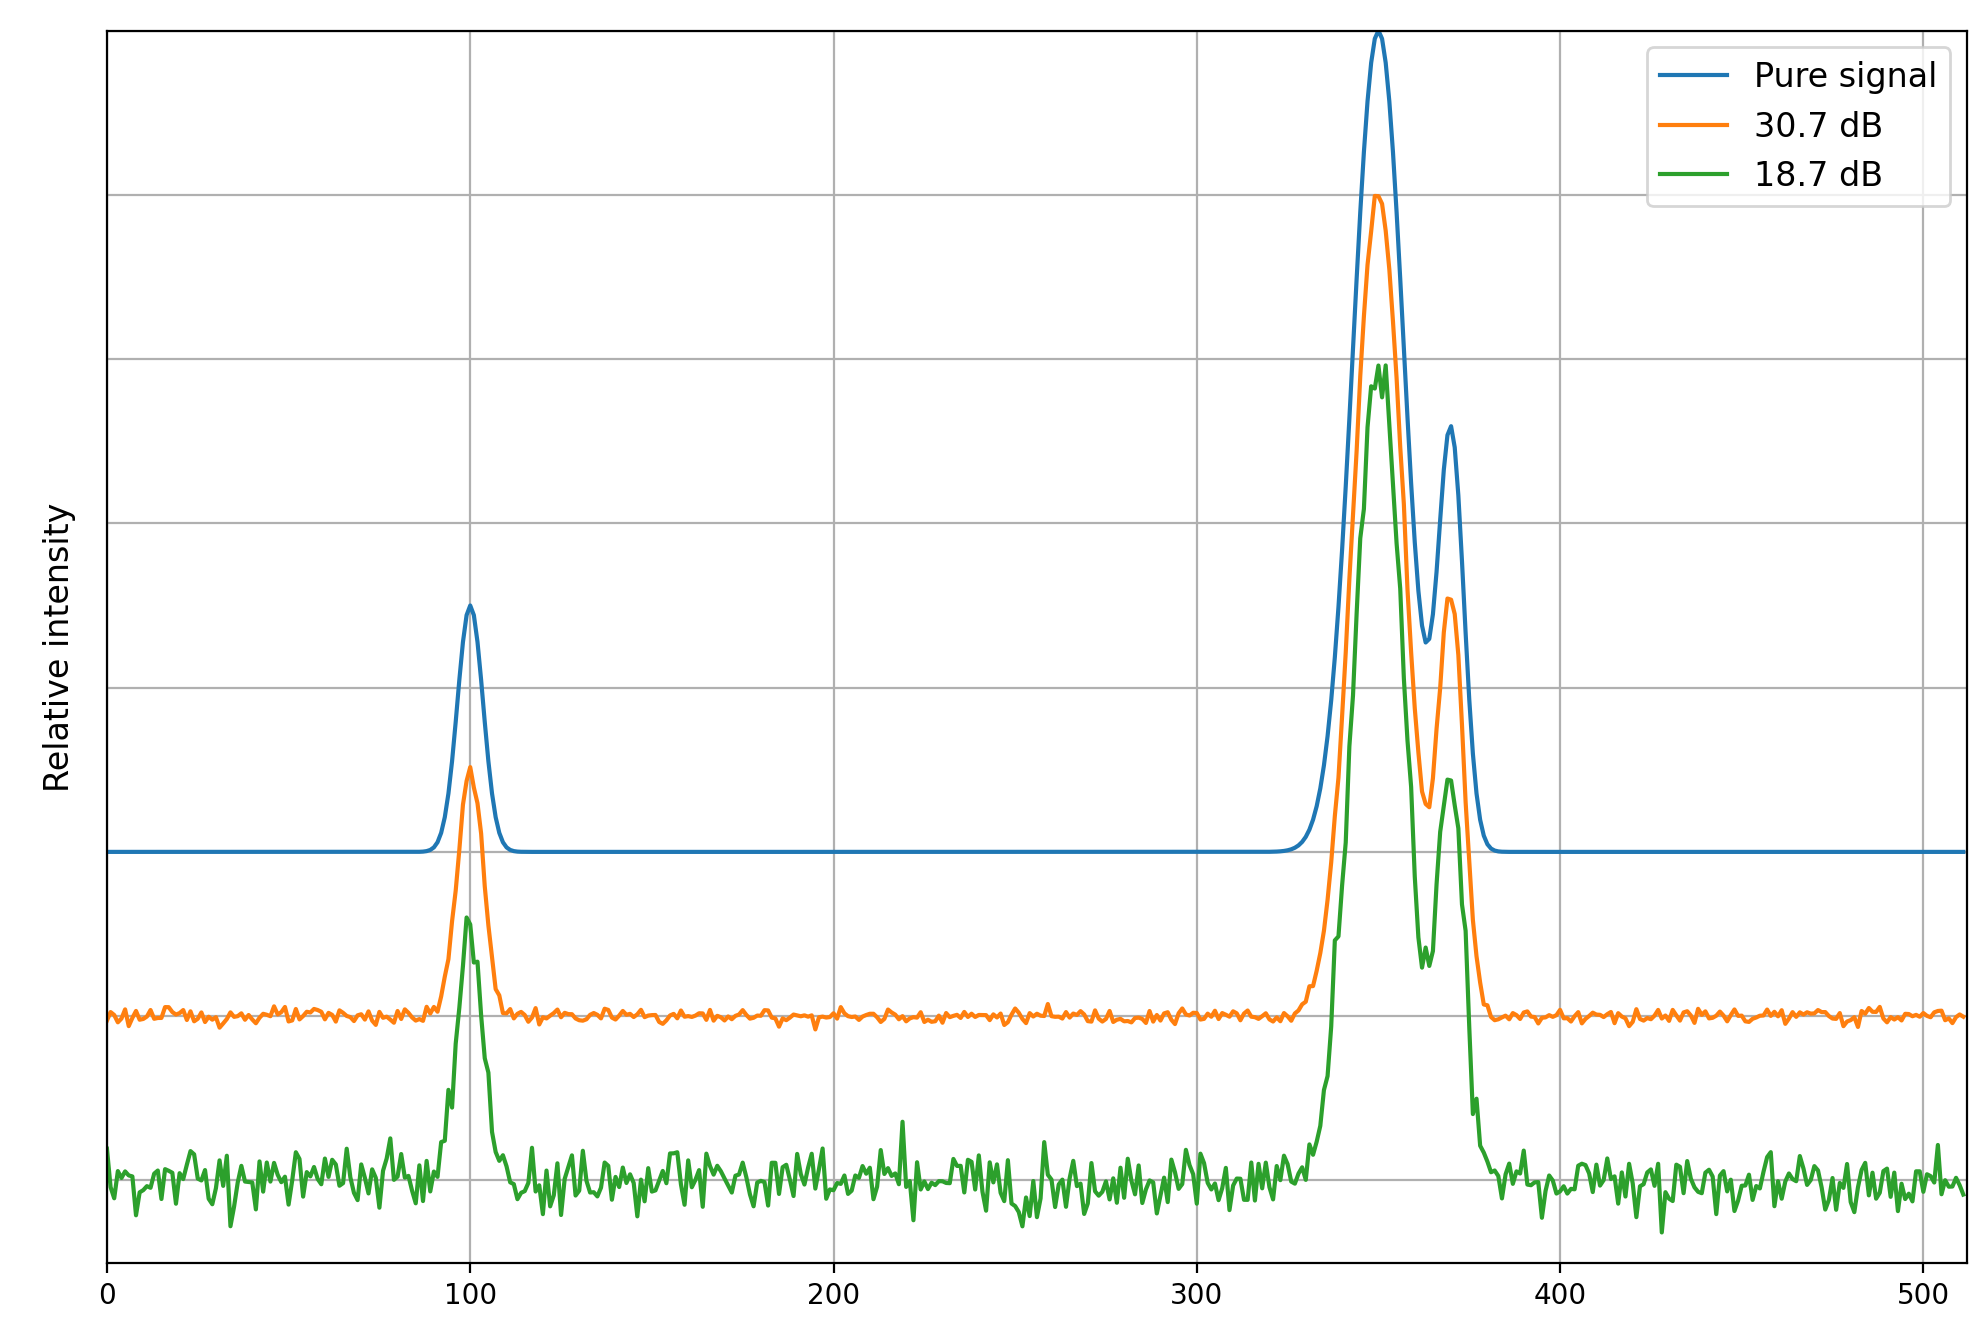

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib

np.random.seed(123)
fm = matplotlib.font_manager.FontProperties()
fm.set_size(10)

i = np.linspace(0, 511, num=512, endpoint=True, dtype=int)

simData = 0.3*np.exp(-((i-100)/5)**2) + 1*np.exp(-((i-350)/10)**2) + 0.5*np.exp(-((i-370)/5)**2)
simMax, simMin = simData.max(), simData.min()
simData -= simMin
simData /= (simMax - simMin)

noise1 = np.random.normal(size= 512, scale=0.005) #scale: standard deviation
noise2 = np.random.normal(size= 512, scale=0.02)

simDataNoise1 = simData+noise1
simDataNoise2 = simData+noise2

plt.figure(figsize=(12, 8))
plt.plot(simData, label='Pure signal')
plt.plot(simDataNoise1-0.2, label=f'{round(SNR(simData, noise1), 1)} dB')
plt.plot(simDataNoise2-0.4, label=f'{round(SNR(simData, noise2), 1)} dB')
plt.grid(True)
plt.xlim(0,512)
plt.ylim(-0.5, 1)
plt.yticks(alpha=0)
plt.tick_params(axis='y', width=0)
plt.ylabel("Relative intensity", fontsize=12, labelpad=-20)
plt.legend(fontsize=12)

#eps_fig =  plt.gcf()
#eps_fig.savefig('C:\\Users\\CHENTIEJUN\\Desktop\\ipp\\simNoiseData.eps', transparent=True, bbox_inches='tight', format='eps',dpi=1000)

plt.show()

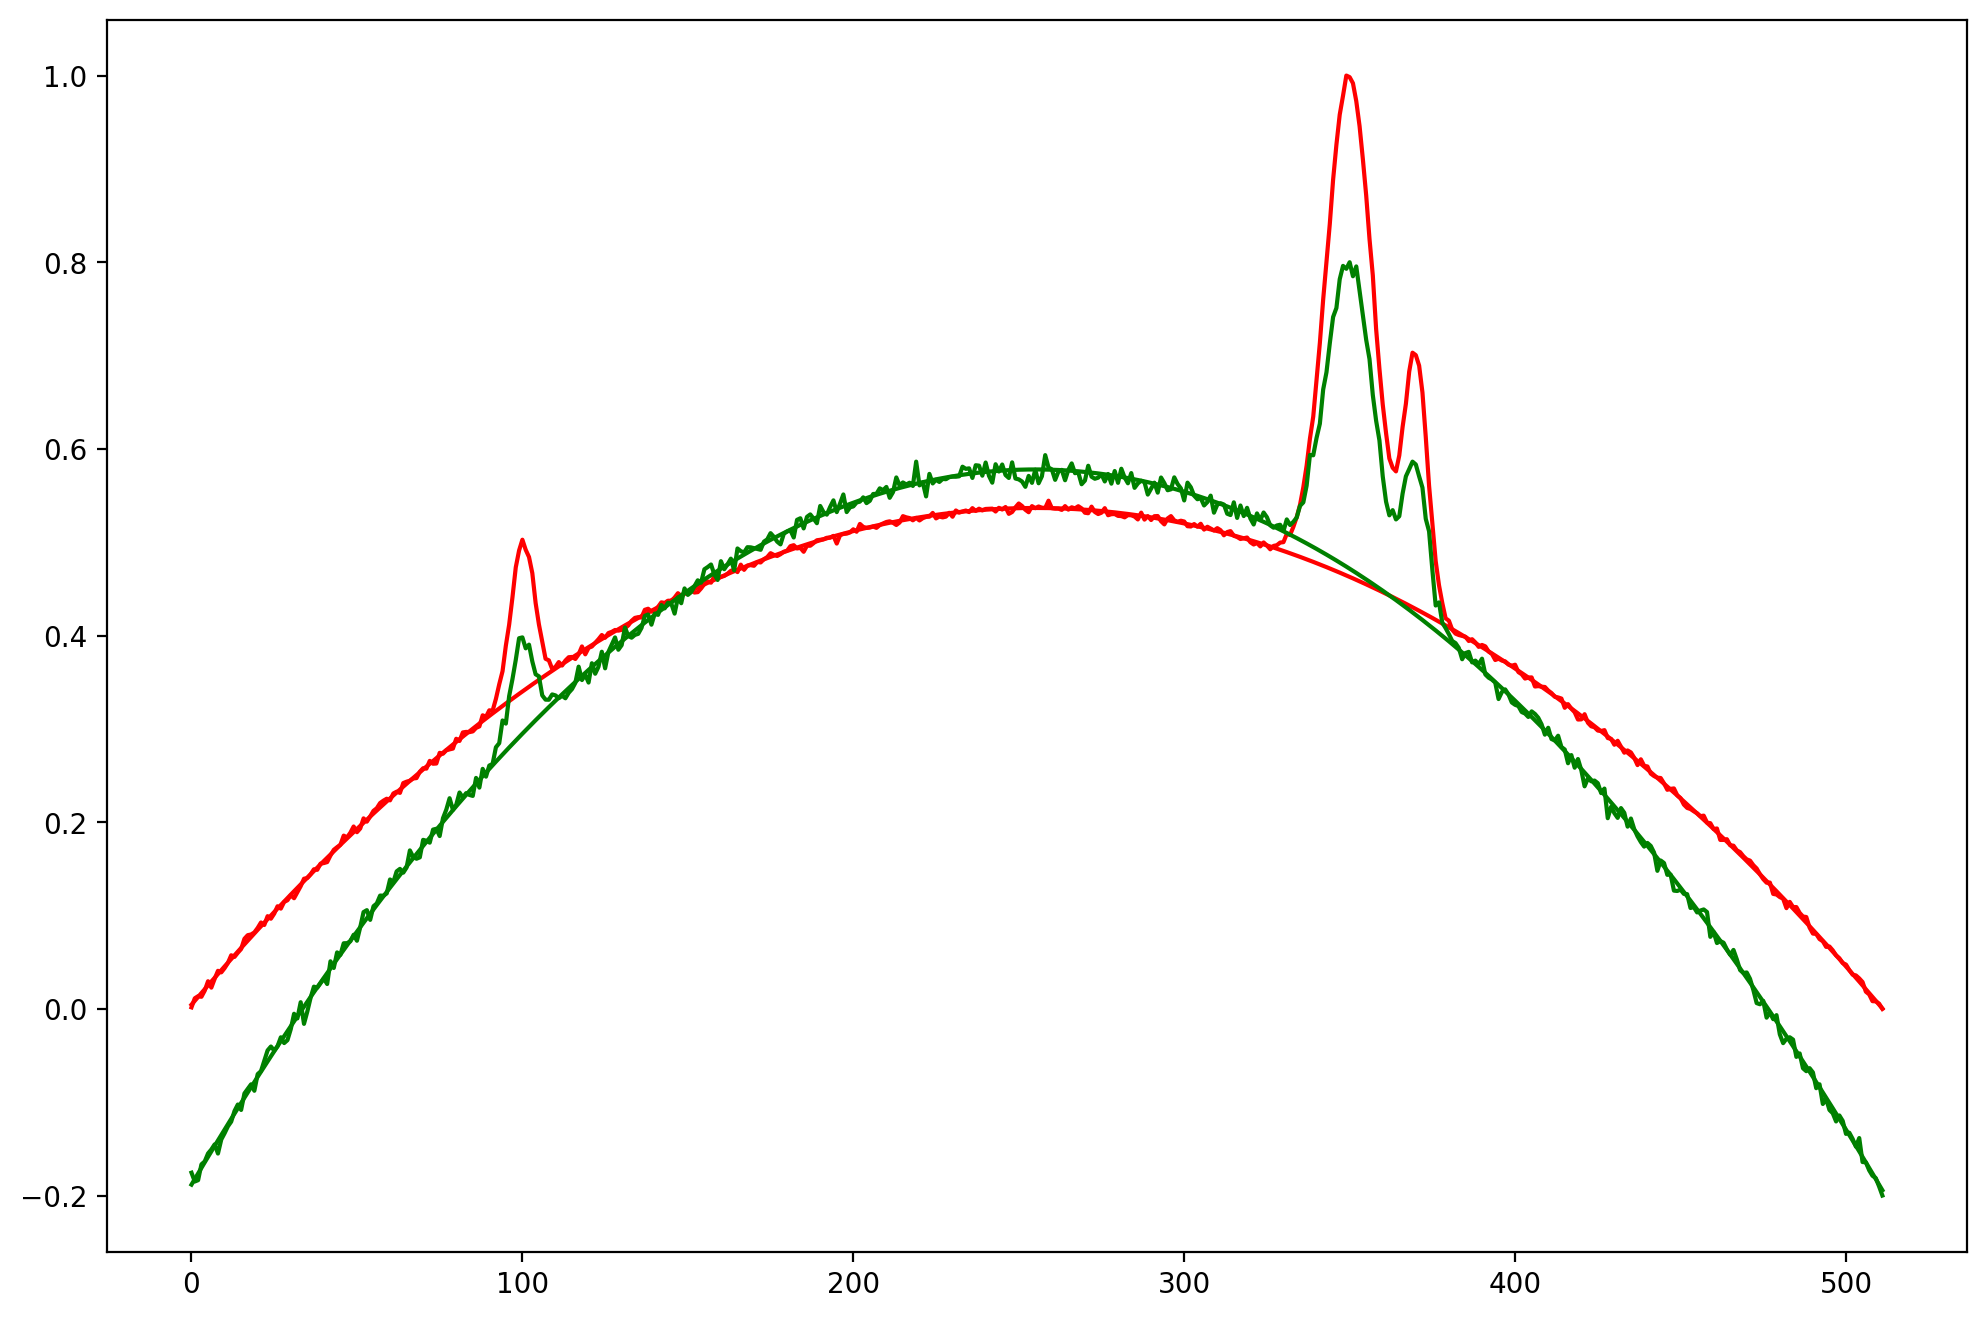

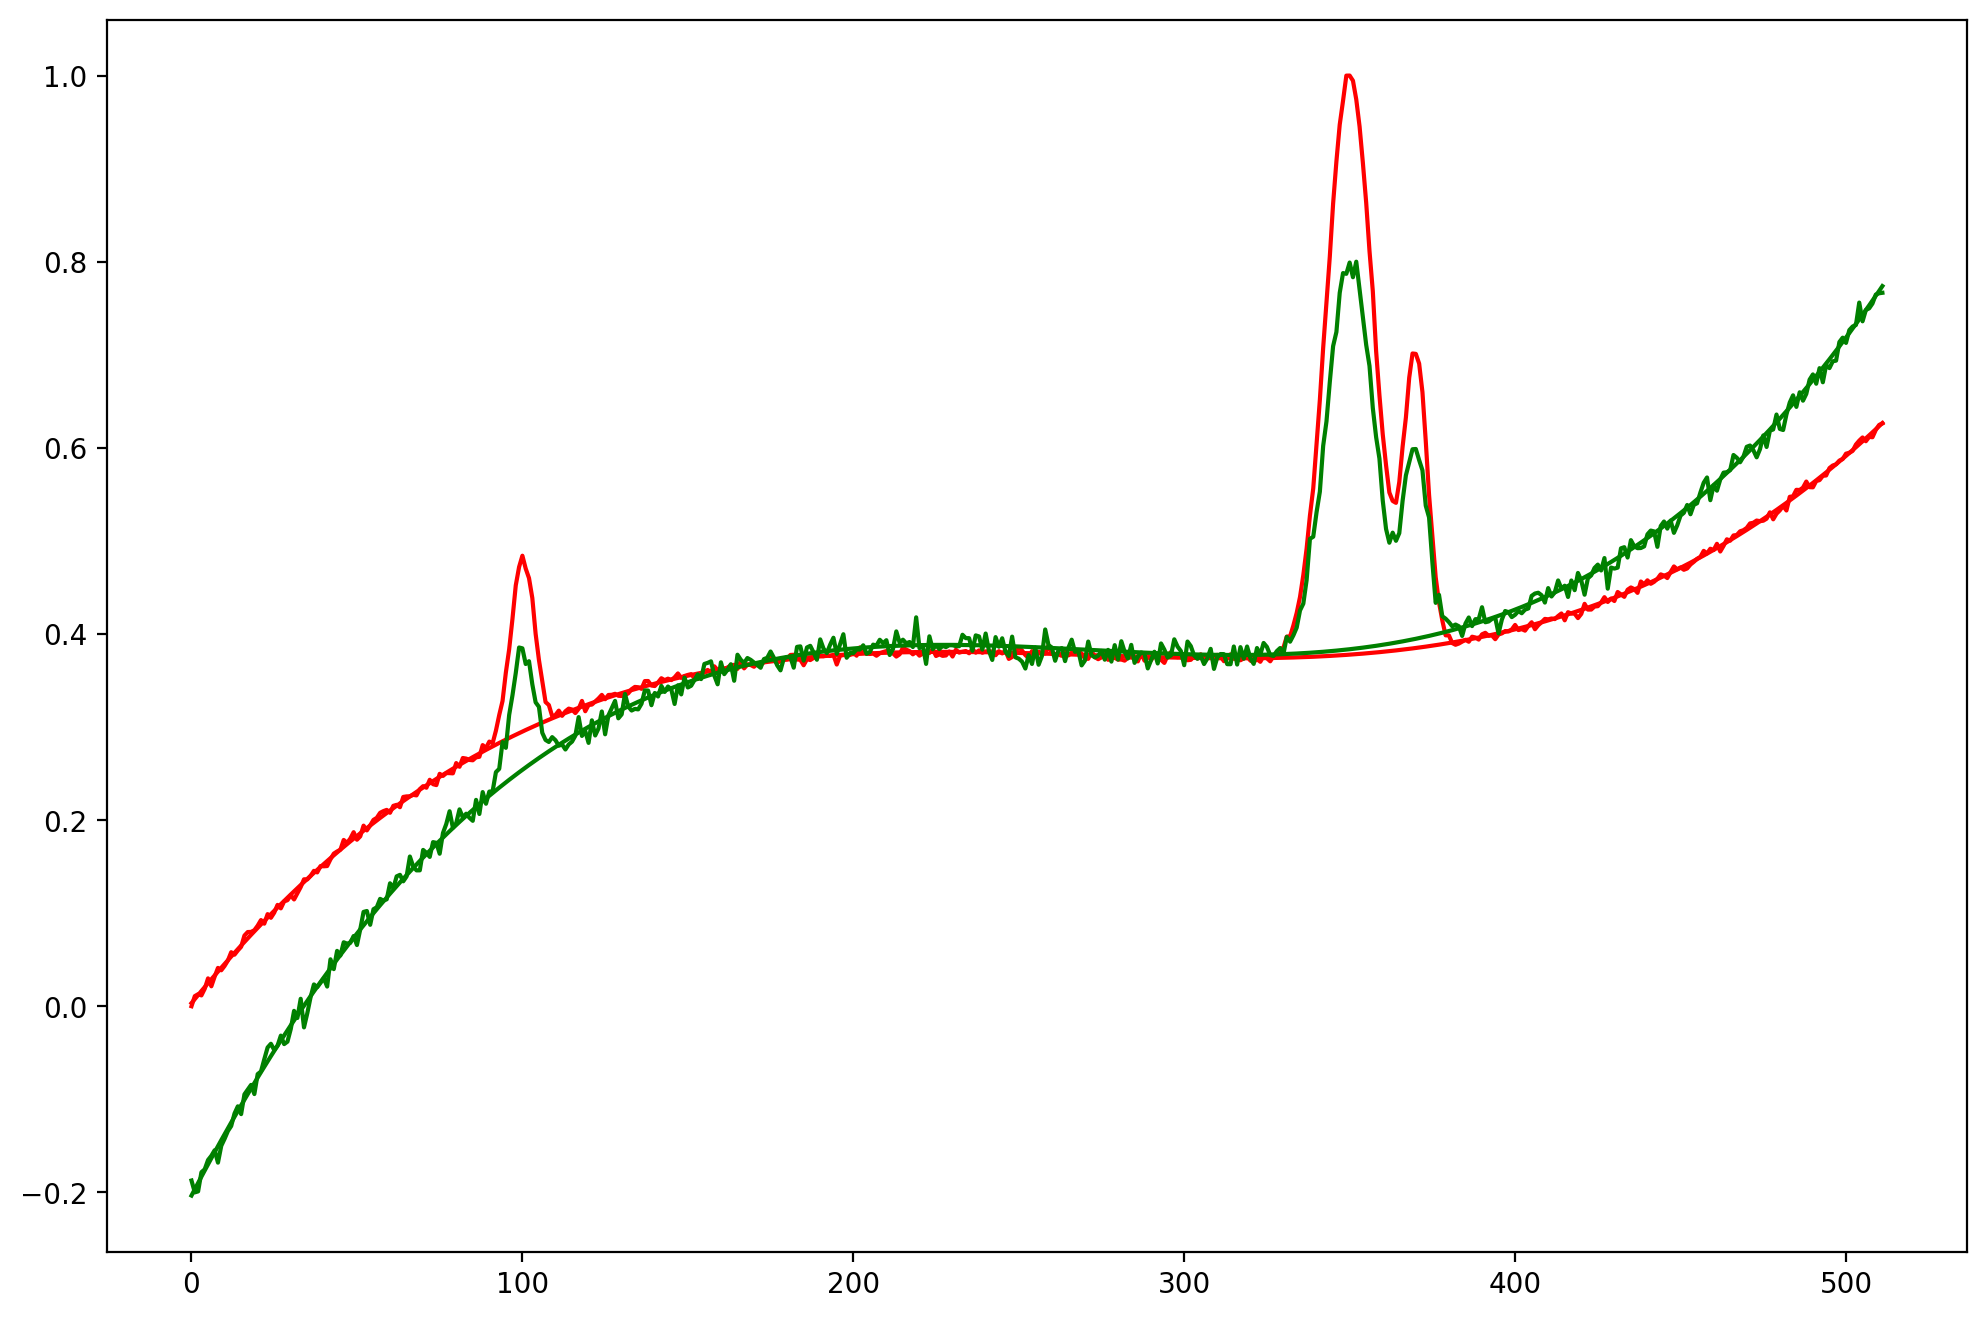

In [ ]:
xAxis = np.linspace(-255, 256, num=512, endpoint=True, dtype=int)
base1 = -(xAxis-30)*(xAxis+30)
base2 = (xAxis-100)*(xAxis-0)*(xAxis+50)

baseRatio1 = 0.5
baseRatio2 = 0.7
peakRatio1 = 1 - baseRatio1
peakRatio2 = 1 - baseRatio2

baseMin1, baseMax1 = base1.min(), base1.max()
delt1 = baseMax1-baseMin1
base1 -= baseMin1
base1 = base1 / delt1

baseMin2, baseMax2 = base2.min(), base2.max()
delt2 = baseMax2-baseMin2
base2 -= baseMin2
base2 = base2 / delt2

noiseData1 = base1*baseRatio1+simDataNoise1*peakRatio1
nDataMin1, nDataMax1 = noiseData1.min(), noiseData1.max()
noiseData1 -= nDataMin1
noiseData1 /= (nDataMax1-nDataMin1)
nBase1 = base1*baseRatio1
nBase1 -= nDataMin1
nBase1 /= (nDataMax1-nDataMin1)

noiseData2 = base1*baseRatio2+simDataNoise2*peakRatio2
nDataMin2, nDataMax2 = noiseData2.min(), noiseData2.max()
noiseData2 -= nDataMin2
noiseData2 /= (nDataMax2-nDataMin2)
nBase2 = base1*baseRatio2
nBase2 -= nDataMin2
nBase2 /= (nDataMax2-nDataMin2)

plt.figure(figsize=(12, 8))
plt.plot(noiseData1, 'r')
plt.plot(nBase1, 'r')
plt.plot(noiseData2-0.2, 'g')
plt.plot(nBase2-0.2, 'g')
plt.show()

noiseData3 = base2*baseRatio1+simDataNoise1*peakRatio1
nDataMin3, nDataMax3 = noiseData3.min(), noiseData3.max()
noiseData3 -= nDataMin3
noiseData3 /= (nDataMax3-nDataMin3)
nBase3 = base2*baseRatio1
nBase3 -= nDataMin3
nBase3 /= (nDataMax3-nDataMin3)

noiseData4 = base2*baseRatio2+simDataNoise2*peakRatio2
nDataMin4, nDataMax4 = noiseData4.min(), noiseData4.max()
noiseData4 -= nDataMin4
noiseData4 /= (nDataMax4-nDataMin4)
nBase4 = base2*baseRatio2
nBase4 -= nDataMin4
nBase4 /= (nDataMax4-nDataMin4)

plt.figure(figsize=(12, 8))
plt.plot(noiseData3, 'r')
plt.plot(nBase3, 'r')
plt.plot(noiseData4-0.2, 'g')
plt.plot(nBase4-0.2, 'g')
plt.show()

/tmp/ipykernel_316260/2323565729.py:38: RuntimeWarning: overflow encountered in exp
  wt = 1 / (1+np.exp(2*(d-s)/s))


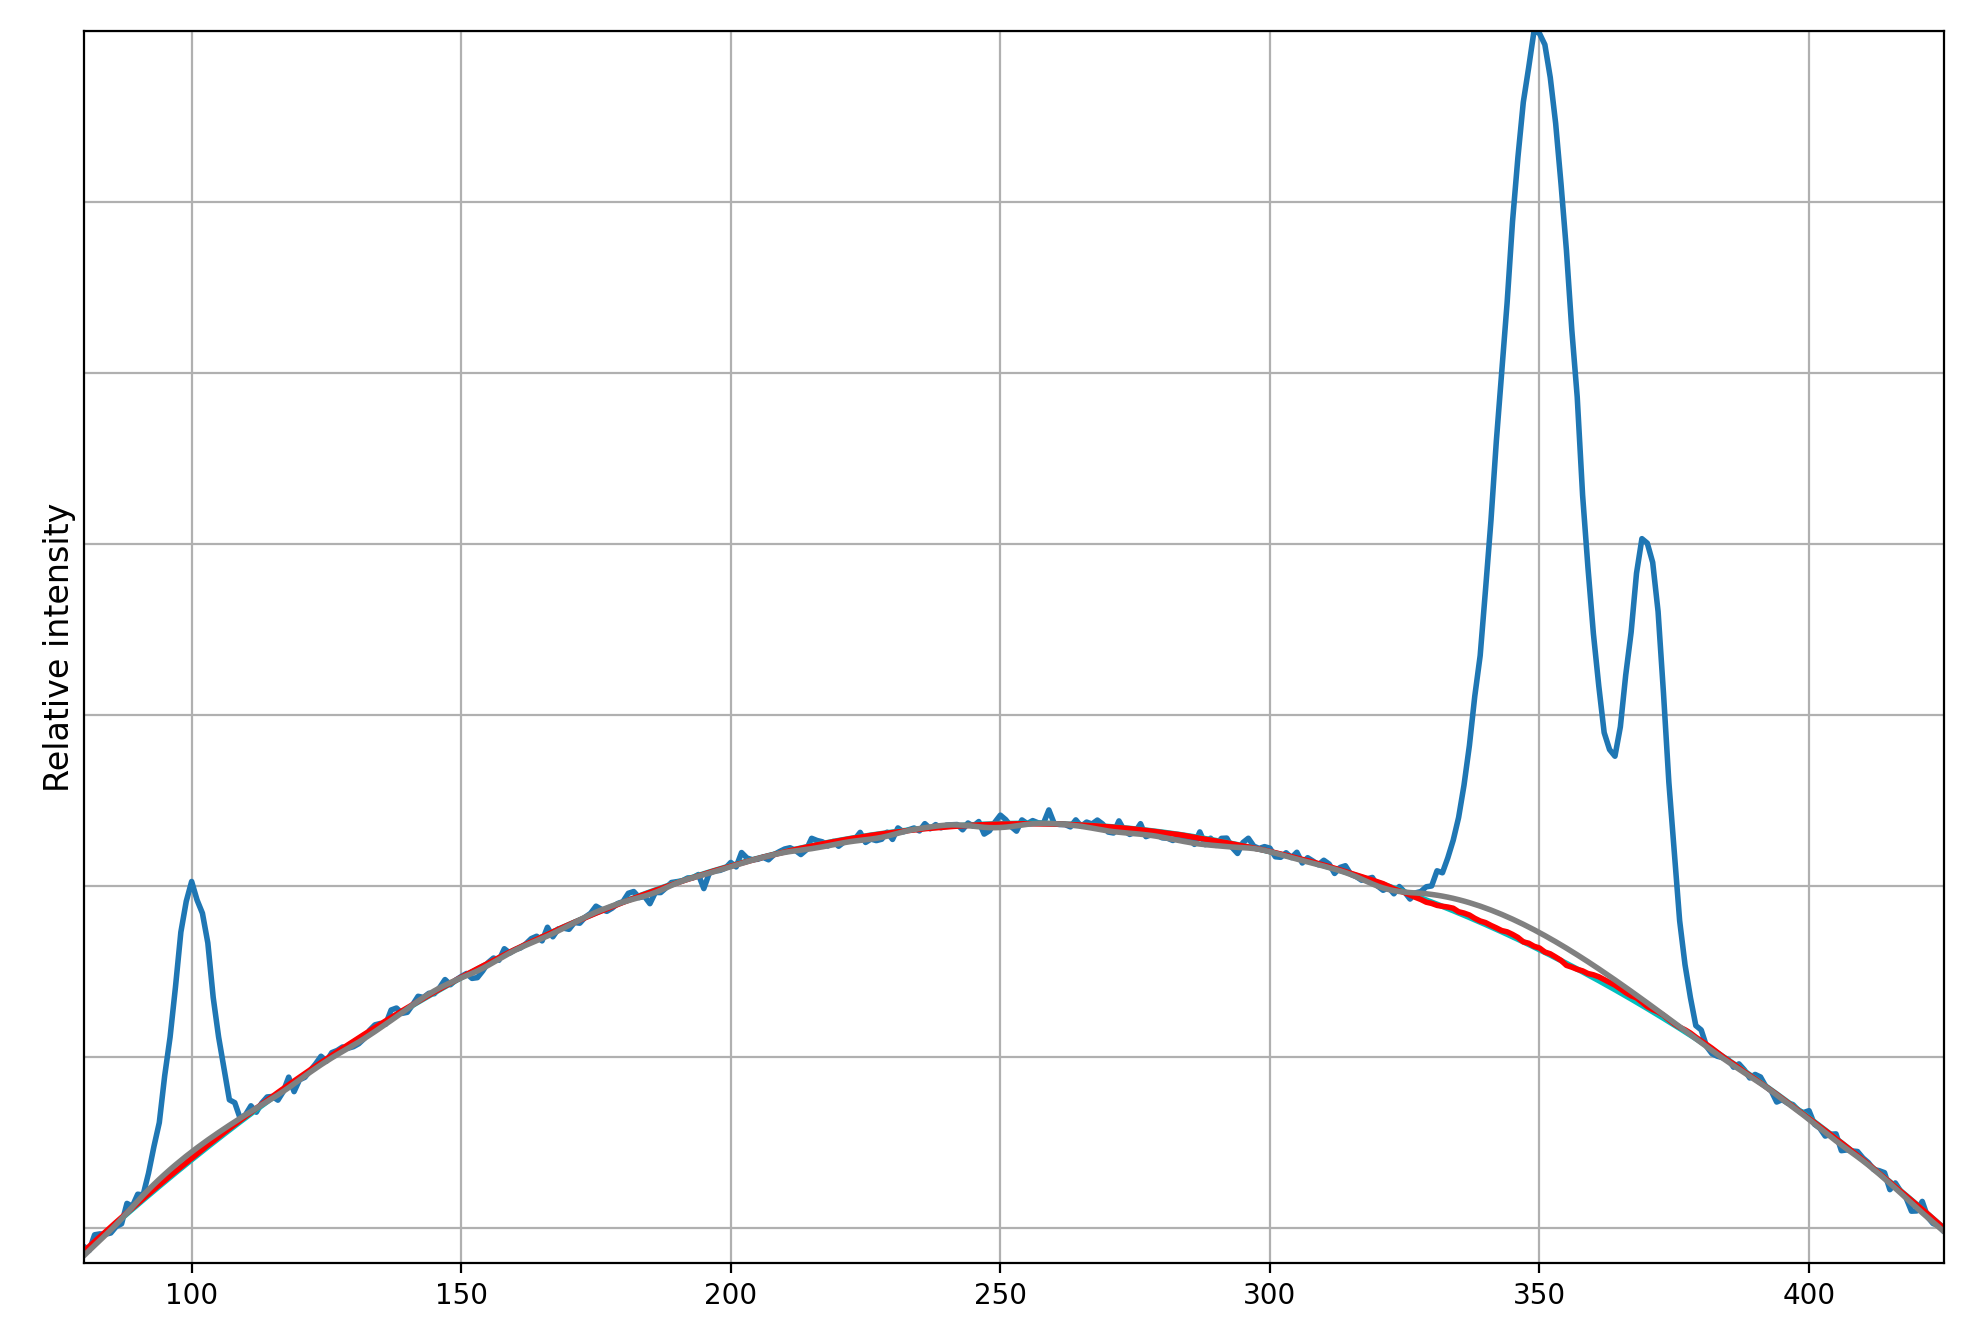

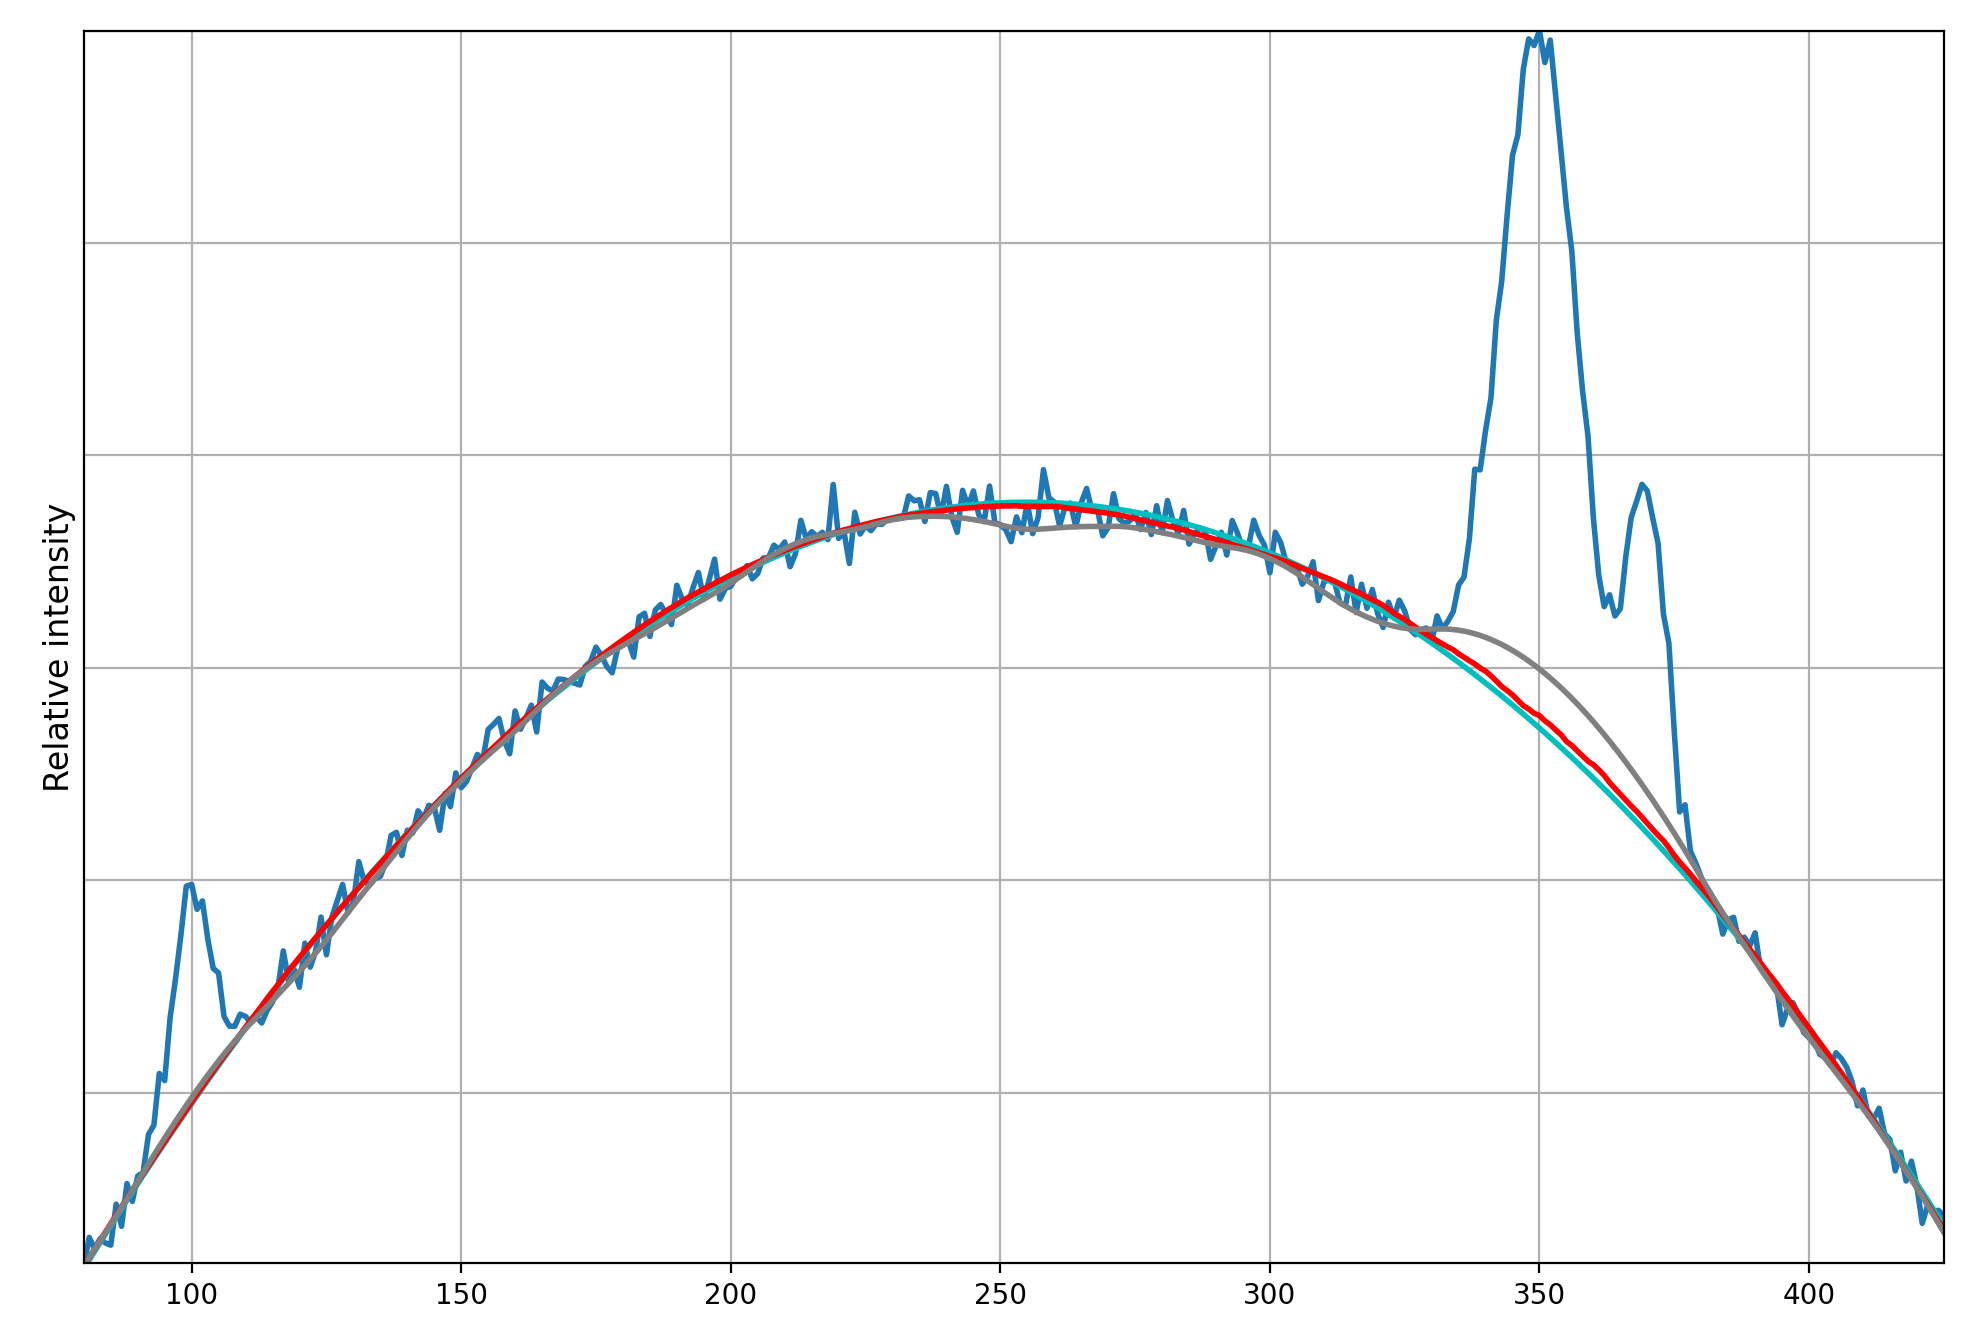

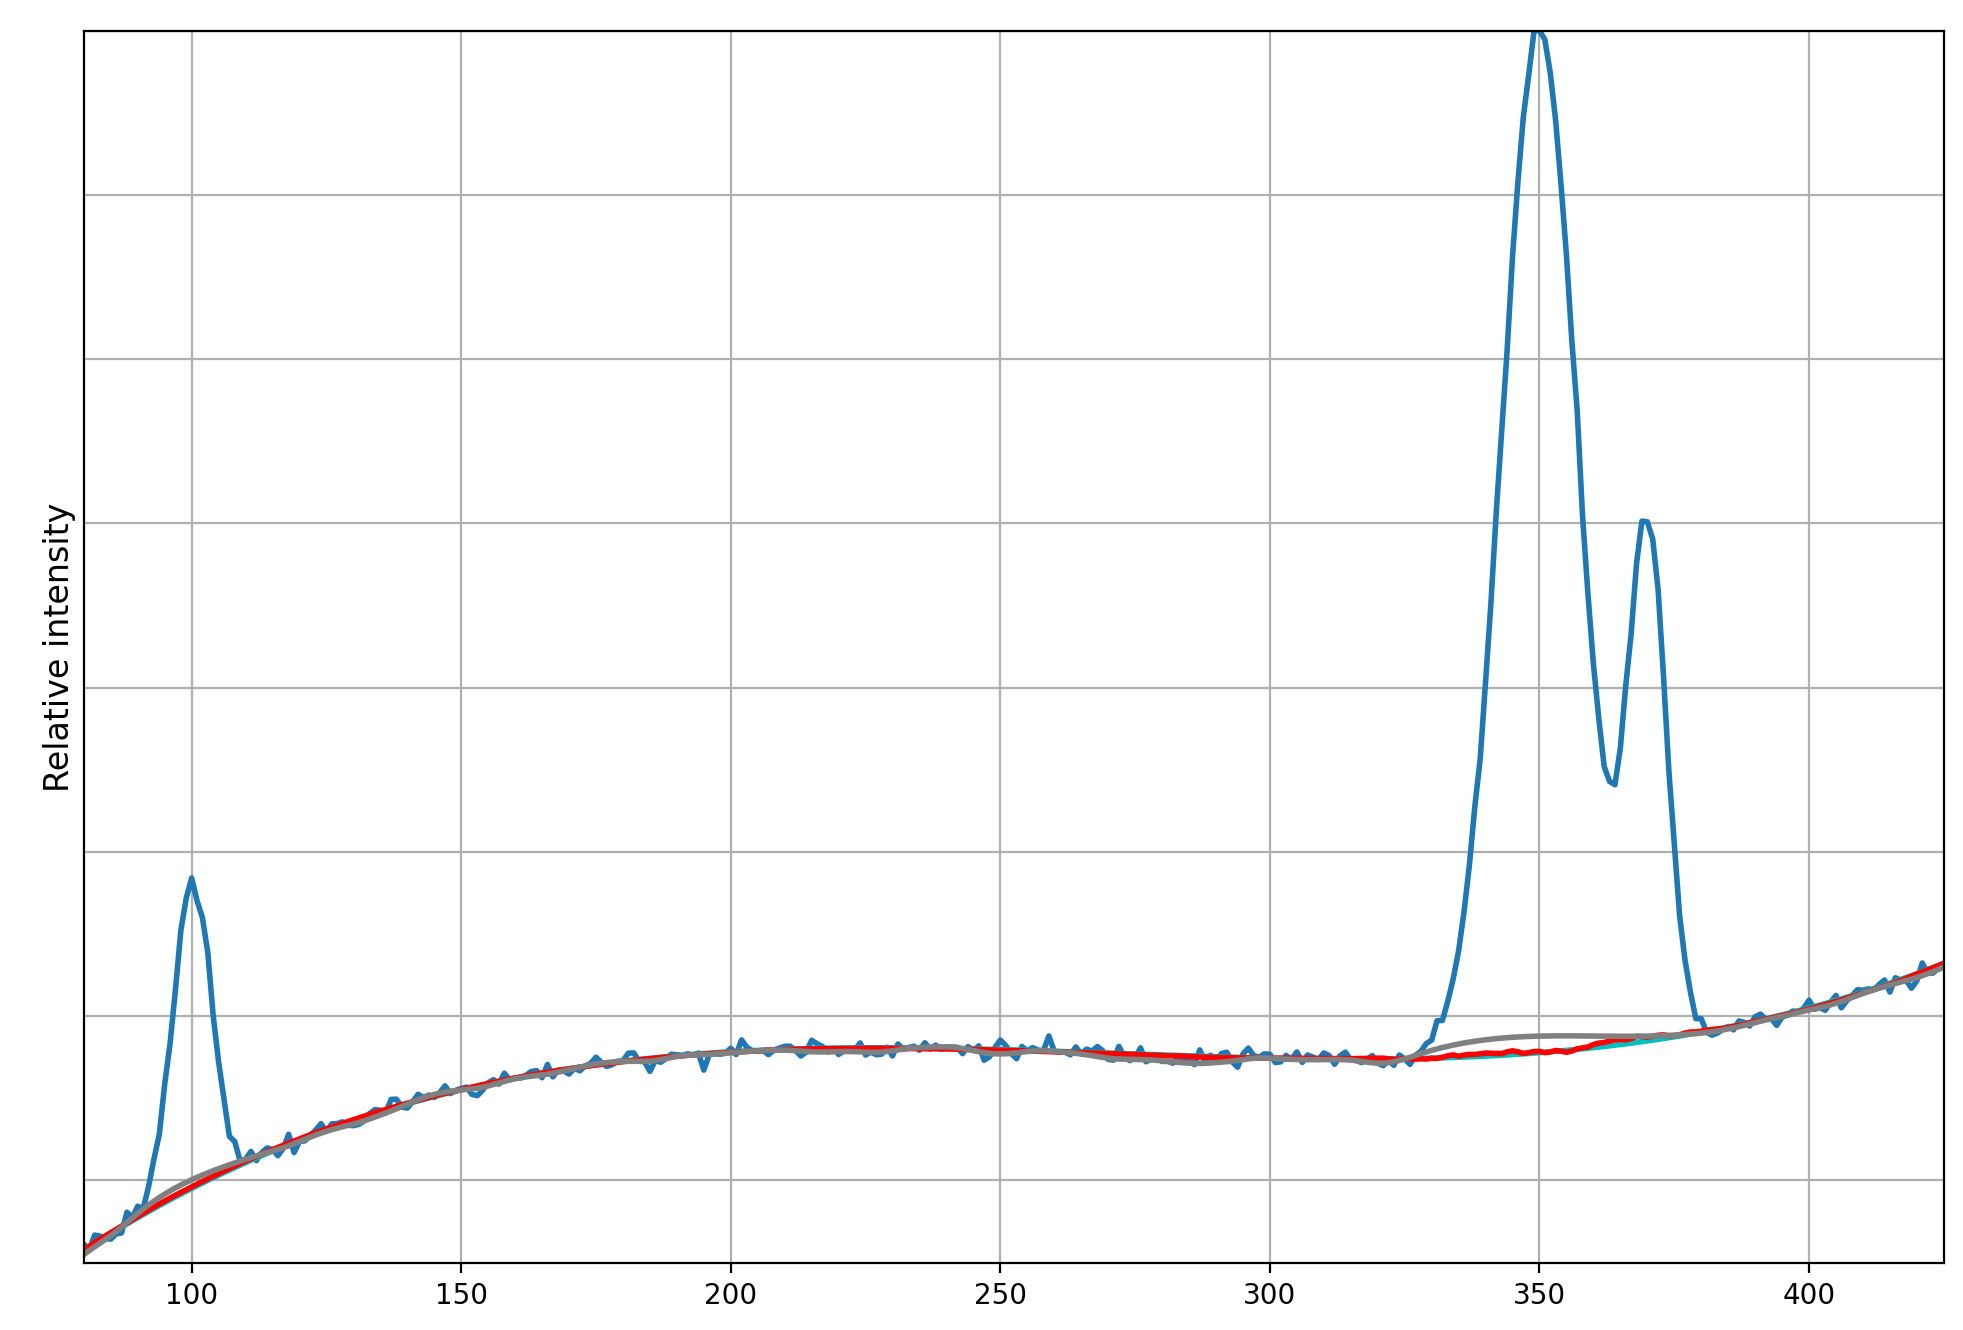

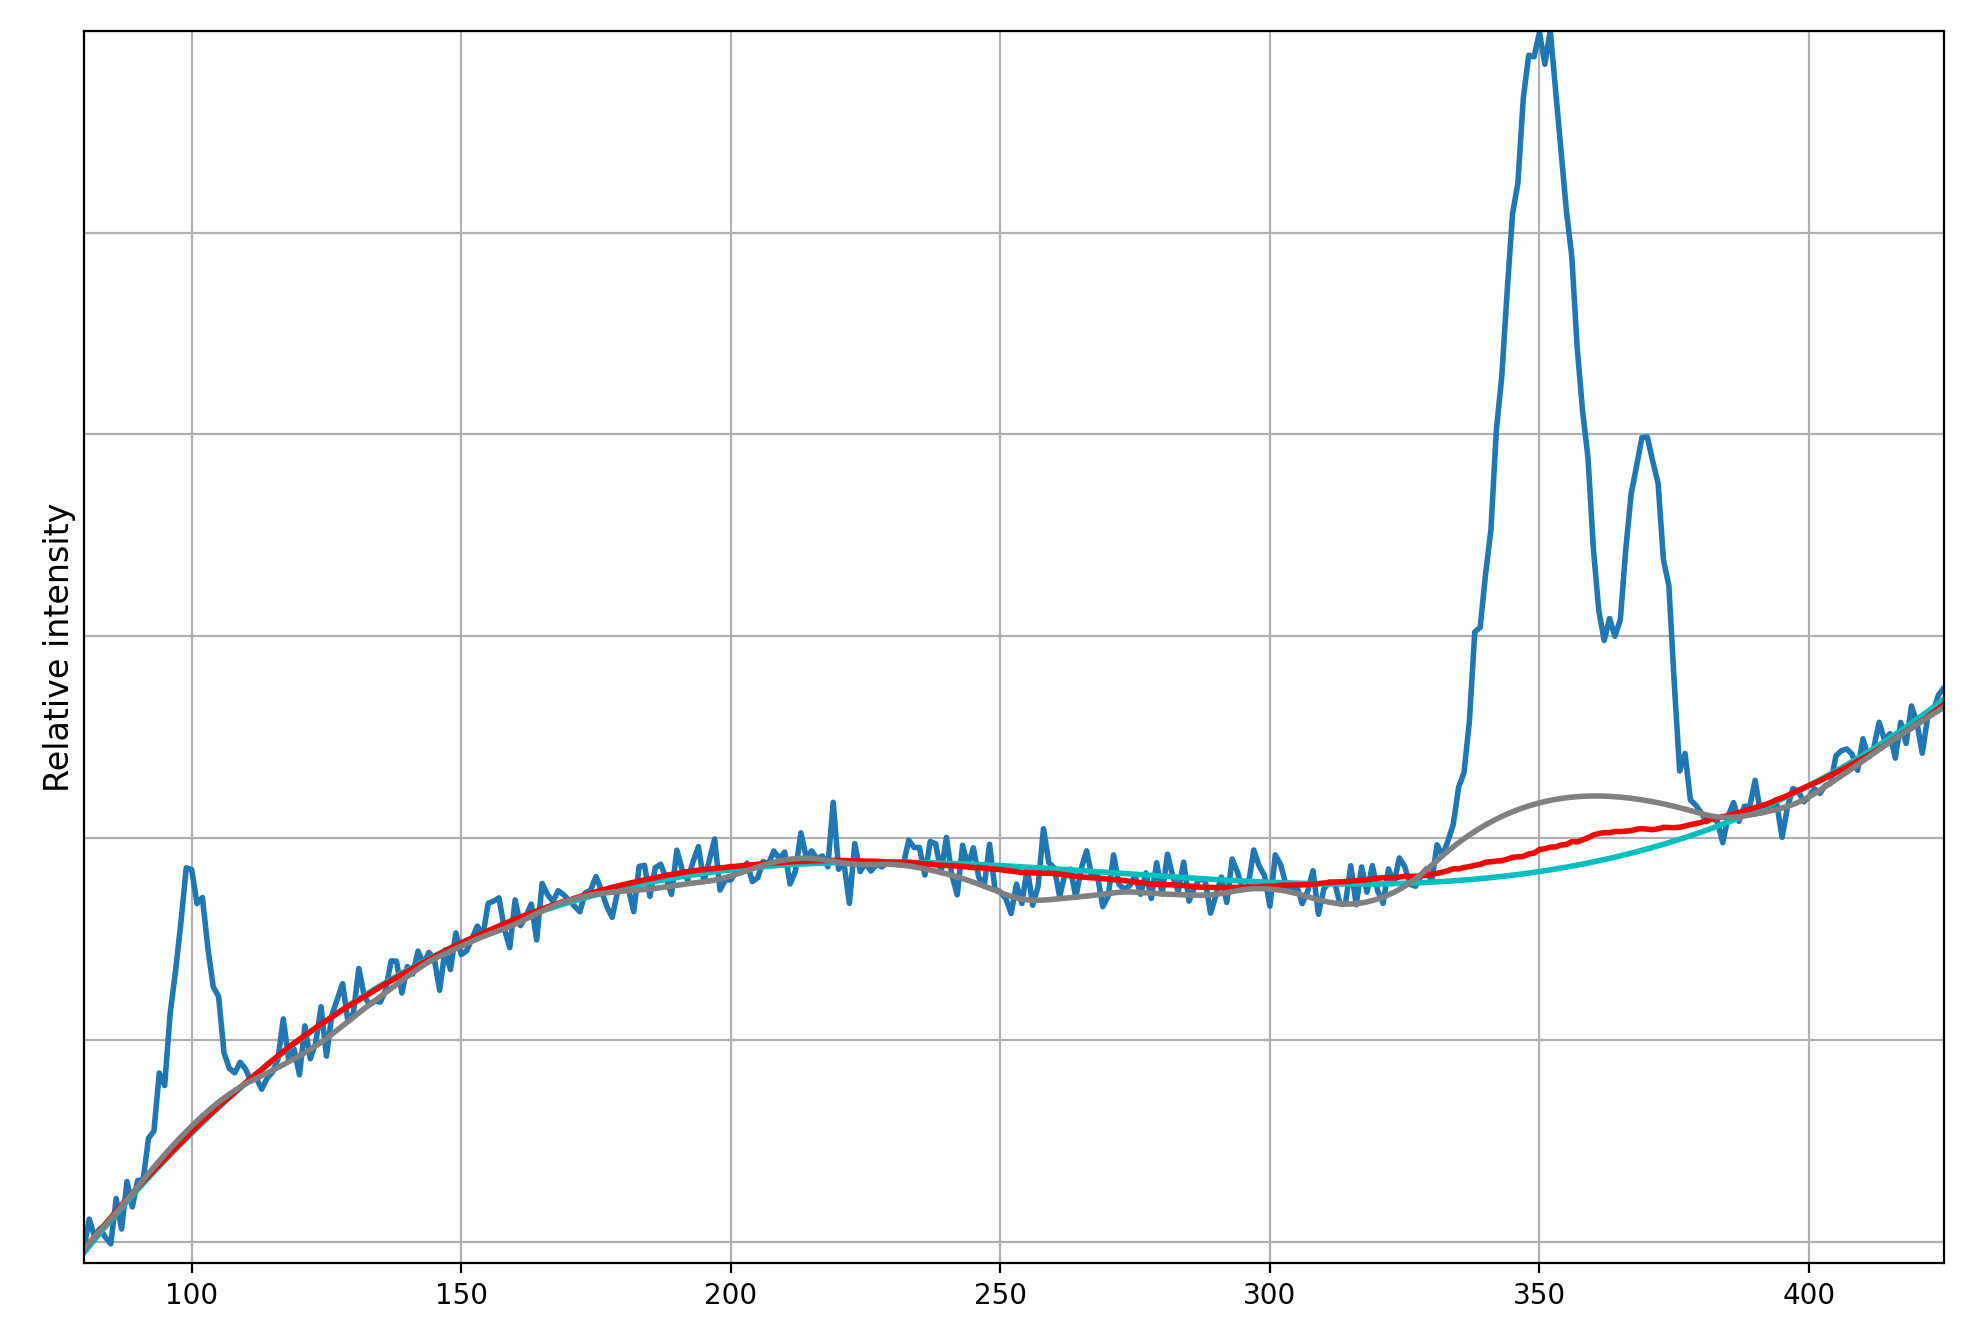

In [ ]:
datas = [noiseData1, noiseData2, noiseData3, noiseData4]
baselines = [nBase1, nBase2, nBase3, nBase4]

import scipy.sparse as sp

simpleResTri.eval()
with torch.no_grad():
    for i, (inZ, trueY) in enumerate(zip(datas,baselines)):
        nInput = torch.tensor(inZ, dtype=torch.float32)
        netY = simpleResTri(nInput).view(-1).numpy()

        _, bgData,_,_,_ = bgasPLS(np.array([inZ]), lambd=10000)

        plt.figure(figsize=(12, 8))
        plt.plot(inZ, linewidth=2)
        plt.plot(trueY, 'c', linewidth=2)
        plt.plot(netY, 'r', linewidth=2)
        plt.plot(bgData[0], 'gray', linewidth=2)

        plt.grid(True)
        plt.xlim(80,425)
        if i == 0: plt.ylim(0.28, 1)
        if i == 1: plt.ylim(0.42, 1)
        if i == 2: plt.ylim(0.25, 1)
        if i == 3: plt.ylim(0.39, 1)
        plt.yticks(alpha=0)
        plt.tick_params(axis='y', width=0)
        plt.ylabel("Relative intensity", fontsize=12, labelpad=-20)

        plt.show()